In [8]:
import librosa
import numpy as np
import os

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Dense, Dropout, BatchNormalization, Input, GlobalAveragePooling2D
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

import seaborn as sns

2024-12-08 19:25:29.376560: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-08 19:25:29.521341: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-08 19:25:29.596032: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-08 19:25:29.727325: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-08 19:25:29.756492: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-08 19:25:29.924889: I tensorflow/core/platform/cpu_feature_gu

# Data Cleaning and Preprocessing

## Convert all audio files to spectrograms

In [9]:
def extract_mel_spectrogram(audio_file_path):
    y, sr = librosa.load(audio_file_path)

    mel_spectrogram = librosa.feature.melspectrogram(
        y=y,
        sr=sr,
        n_mels=128,
        n_fft=2048,
        hop_length=512
    )

    S_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
    return (S_db, sr)

In [ ]:
# Dataset downloaded from https://www.kaggle.com/datasets/abdulvahap/music-instrunment-sounds-for-classification


input_root = "music_dataset"
output_root = "spectrograms"

# Ensure the destination folder exists
if not os.path.exists(output_root):
    os.makedirs(output_root)

# Convert each audio in each instrument folder
for instrument_dir in os.listdir(input_root):
    audio_input_path = os.path.join(input_root, instrument_dir)

    # If the instrument directory doesn't exist, create it
    instrument_output_dir = os.path.join(output_root, instrument_dir)
    if not os.path.exists(instrument_output_dir):
        os.makedirs(instrument_output_dir)
    
    # Go through each audio file and save the spectrogram
    for audio_file in os.listdir(audio_input_path):
        audio_file_path = os.path.join(audio_input_path, audio_file)

        S_db, _ = extract_mel_spectrogram(audio_file_path)

        spectrogram_file_name = os.path.splitext(audio_file)[0] + '.npy'
        spectrogram_file_path = os.path.join(instrument_output_dir, spectrogram_file_name)
        np.save(spectrogram_file_path, S_db)

## Preparing Data

In [32]:
def get_file_paths_and_labels(spectrogram_root):
    """
    Get paths to all spectrograms and their corresponding labels
    without loading the actual data
    """
    file_paths = []
    labels = []
    
    for instrument in os.listdir(spectrogram_root):
        instrument_dir = os.path.join(spectrogram_root, instrument)
        
        if os.path.isdir(instrument_dir):
            for spectrogram_file in os.listdir(instrument_dir):
                if spectrogram_file.endswith(".npy"):
                    file_paths.append(os.path.join(instrument_dir, spectrogram_file))
                    labels.append(instrument)
    
    return file_paths, labels

In [33]:
def calculate_class_weights(labels):
    """
    Takes a list of labels and returns a dictionary 
    with the weight of each class.
    """
    unique_classes, class_counts = np.unique(labels, return_counts=True)
    class_weights = {}
    total_samples = len(labels)
    n_classes = len(unique_classes)

    for idx, class_label in enumerate(unique_classes):
        class_weights[idx] = total_samples / (n_classes * class_counts[idx])
    
    return class_weights

In [43]:
def create_dataset_splits(
        file_paths,
        train_size=0.7,
        val_size=0.15,
        random_state=42
):
    """
    Splits the data set by index since the full data set can't be loaded.
    """
    # Calculate the validation and test sizes relative to what remains after train split
    remaining_fraction = 1 - train_size
    relative_val_size = val_size / remaining_fraction
    
    # Create initial train/temp split
    indices = np.arange(len(file_paths))
    train_idx, temp_idx = train_test_split(
        indices,
        train_size=train_size,
        random_state=random_state
    )
    
    # Split the remaining data into validation and test sets
    val_idx, test_idx = train_test_split(
        temp_idx,
        train_size=relative_val_size,
        random_state=random_state
    )
    
    return {
        'train_indices': train_idx,
        'validation_indices': val_idx,
        'test_indices': test_idx
    }

In [44]:
def create_dataset_generator(
        file_paths,
        labels,
        batch_size=32,
        is_training=True,
        class_weights=None
):
    """
    Creates a dataset generator that yields samples in batches.
    """
    indices = np.arange(len(file_paths))

    while True:
        if is_training:
            np.random.shuffle(indices)
        
        for start_idx in range(0, len(indices), batch_size):
            batch_indices = indices[start_idx:start_idx + batch_size]

            batch_spectrograms = []
            batch_labels = []
            sample_weights = [] if class_weights is not None else None

            for idx in batch_indices:
                spectrogram = np.load(file_paths[idx])
                spectrogram = np.expand_dims(spectrogram, axis=-1)

                batch_spectrograms.append(spectrogram)
                batch_labels.append(labels[idx])

                if class_weights is not None:
                    weight = class_weights[labels[idx]]
                    sample_weights.append(weight)

            batch_x = np.array(batch_spectrograms)
            batch_y = np.array(batch_labels)
            
            if sample_weights:
                batch_weights = np.array(sample_weights)
                yield batch_x, batch_y, batch_weights
            else:
                yield batch_x, batch_y

def reset_generators(file_paths, encoded_labels, dataset_splits, batch_size=32):
    """
    Creates three generators based on the splits provided and gets the class weights.
    """
    # Extract indices from the stored splits
    train_idx = dataset_splits['train_indices']
    val_idx = dataset_splits['validation_indices']
    test_idx = dataset_splits['test_indices']
    
    # Create file path and label lists for each split
    train_paths = [file_paths[i] for i in train_idx]
    train_labels = [encoded_labels[i] for i in train_idx]
    
    val_paths = [file_paths[i] for i in val_idx]
    val_labels = [encoded_labels[i] for i in val_idx]
    
    test_paths = [file_paths[i] for i in test_idx]
    test_labels = [encoded_labels[i] for i in test_idx]
    
    # Calculate class weights using training data only
    class_weights = calculate_class_weights(train_labels)
    
    # Create generators
    train_generator = create_dataset_generator(
        train_paths, train_labels,
        batch_size=batch_size,
        is_training=True,
        class_weights=class_weights
    )
    
    val_generator = create_dataset_generator(
        val_paths, val_labels,
        batch_size=batch_size,
        is_training=False
    )
    
    test_generator = create_dataset_generator(
        test_paths, test_labels,
        batch_size=batch_size,
        is_training=False
    )
    
    # Calculate steps
    steps_per_epoch = len(train_paths) // batch_size
    validation_steps = len(val_paths) // batch_size
    test_steps = len(test_paths) // batch_size
    
    return {
        'train_generator': train_generator,
        'val_generator': val_generator,
        'test_generator': test_generator,
        'steps_per_epoch': steps_per_epoch,
        'validation_steps': validation_steps,
        'test_steps': test_steps,
        'class_weights': class_weights
    }



In [45]:
file_paths, labels = get_file_paths_and_labels("spectrograms")

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

sample_spectrogram = np.load(file_paths[0])
input_shape = (*sample_spectrogram.shape, 1)
num_classes = len(label_encoder.classes_)

dataset_splits = create_dataset_splits(file_paths)

# Model Training

In [35]:
def create_spectrogram_model(input_shape, num_classes):
    """
    Creates my starting point model on demand.
    """
    model = Sequential([
        Input(shape=input_shape),
        
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((4, 4)),
        BatchNormalization(),
        Dropout(0.25),
        
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((4, 4)),
        BatchNormalization(),
        Dropout(0.25),
        
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Dropout(0.25),
        
        GlobalAveragePooling2D(),
        
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [36]:
def create_and_train_model(num_epochs):
    """
    Creates and trains a model for the specified number of epochs,
    ensuring fresh generators for each training session.
    
    Parameters:
        num_epochs (int): Number of epochs to train for
        
    Returns:
        tuple: (trained model, training history, generator_data)
    """
    # Create fresh generators for this training session
    generator_data = reset_generators(
        file_paths,
        encoded_labels,
        dataset_splits,
        batch_size=32
    )
    
    # Extract components from generator data
    train_generator = generator_data['train_generator']
    val_generator = generator_data['val_generator']
    steps_per_epoch = generator_data['steps_per_epoch']
    validation_steps = generator_data['validation_steps']

    # Create and compile the model
    model = create_spectrogram_model(input_shape, num_classes)
    
    # Train the model
    history = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        validation_data=val_generator,
        validation_steps=validation_steps,
        epochs=num_epochs,
    )
    
    return model, history, generator_data

## Generating the 5 Epoch Model

In [61]:
five_epoch_model, five_epoch_history, generator_data_5 = create_and_train_model(5)

Epoch 1/5
925/925 ━━━━━━━━━━━━━━━━━━━━ 118s 125ms/step - accuracy: 0.4780 - loss: 2.2250 - val_accuracy: 0.6326 - val_loss: 1.2378
Epoch 2/5
925/925 ━━━━━━━━━━━━━━━━━━━━ 115s 124ms/step - accuracy: 0.7746 - loss: 0.8215 - val_accuracy: 0.7979 - val_loss: 0.6035
Epoch 3/5
925/925 ━━━━━━━━━━━━━━━━━━━━ 115s 124ms/step - accuracy: 0.8324 - loss: 0.6196 - val_accuracy: 0.7097 - val_loss: 0.9794
Epoch 4/5
925/925 ━━━━━━━━━━━━━━━━━━━━ 115s 124ms/step - accuracy: 0.8637 - loss: 0.4879 - val_accuracy: 0.6851 - val_loss: 1.0074
Epoch 5/5
925/925 ━━━━━━━━━━━━━━━━━━━━ 115s 124ms/step - accuracy: 0.8835 - loss: 0.4048 - val_accuracy: 0.8337 - val_loss: 0.5565


## Generating the 10 Epoch Model

In [62]:
ten_epoch_model, ten_epoch_history, generator_data_10 = create_and_train_model(10)

Epoch 1/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 117s 124ms/step - accuracy: 0.4906 - loss: 2.0420 - val_accuracy: 0.7642 - val_loss: 0.7416
Epoch 2/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 115s 125ms/step - accuracy: 0.7797 - loss: 0.8291 - val_accuracy: 0.6913 - val_loss: 0.9354
Epoch 3/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 115s 124ms/step - accuracy: 0.8316 - loss: 0.6070 - val_accuracy: 0.6261 - val_loss: 1.1655
Epoch 4/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 115s 125ms/step - accuracy: 0.8646 - loss: 0.4729 - val_accuracy: 0.8185 - val_loss: 0.6067
Epoch 5/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 115s 125ms/step - accuracy: 0.8812 - loss: 0.4265 - val_accuracy: 0.4648 - val_loss: 1.9074
Epoch 6/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 115s 124ms/step - accuracy: 0.8971 - loss: 0.3707 - val_accuracy: 0.9108 - val_loss: 0.2796
Epoch 7/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 115s 124ms/step - accuracy: 0.9135 - loss: 0.3073 - val_accuracy: 0.8541 - val_loss: 0.4383
Epoch 8/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 115s 125ms/step - accuracy: 0.9181 -

## Generating the 7 Epoch Model

In [63]:
seven_epoch_model, seven_epoch_history, generator_data_7 = create_and_train_model(7)

Epoch 1/7
925/925 ━━━━━━━━━━━━━━━━━━━━ 116s 123ms/step - accuracy: 0.4702 - loss: 2.2222 - val_accuracy: 0.7363 - val_loss: 0.8514
Epoch 2/7
925/925 ━━━━━━━━━━━━━━━━━━━━ 114s 123ms/step - accuracy: 0.7792 - loss: 0.8469 - val_accuracy: 0.7990 - val_loss: 0.6684
Epoch 3/7
925/925 ━━━━━━━━━━━━━━━━━━━━ 113s 123ms/step - accuracy: 0.8371 - loss: 0.5991 - val_accuracy: 0.4531 - val_loss: 2.2707
Epoch 4/7
925/925 ━━━━━━━━━━━━━━━━━━━━ 114s 123ms/step - accuracy: 0.8604 - loss: 0.4992 - val_accuracy: 0.8652 - val_loss: 0.4672
Epoch 5/7
925/925 ━━━━━━━━━━━━━━━━━━━━ 114s 123ms/step - accuracy: 0.8829 - loss: 0.4162 - val_accuracy: 0.8944 - val_loss: 0.3503
Epoch 6/7
925/925 ━━━━━━━━━━━━━━━━━━━━ 114s 123ms/step - accuracy: 0.9015 - loss: 0.3436 - val_accuracy: 0.8834 - val_loss: 0.3900
Epoch 7/7
925/925 ━━━━━━━━━━━━━━━━━━━━ 114s 123ms/step - accuracy: 0.9013 - loss: 0.3368 - val_accuracy: 0.9411 - val_loss: 0.1981


# Testing the Models

In [67]:
def evaluate_model_performance(model, test_generator, test_steps, label_encoder, history=None):
    """
    Runs evals on trained models.
    Evaluates the model on the test set, and then makes multiple plots
    to determine model perforamce.

    Creates a confusion matrix, classification report, 
    training history, and per-class accuracy scores.
    """
    # Evaluate overall metrics
    print("Evaluating model on test set...")
    test_metrics = model.evaluate(test_generator, steps=test_steps)
    print(f"\nTest accuracy: {test_metrics[1]:.4f}")
    print(f"\nTest loss: {test_metrics[0]:.4f}\n")
    
    # Get predictions for detailed metrics
    print("Generating predictions for detailed analysis...")
    all_predictions = []
    all_true_labels = []
    
    for i in range(test_steps):
        batch_x, batch_y = next(test_generator)
        predictions = model.predict(batch_x, verbose=0)
        all_predictions.extend(predictions)
        all_true_labels.extend(batch_y)
    
    all_predictions = np.array(all_predictions)
    all_true_labels = np.array(all_true_labels)
    
    # Convert predictions to class labels
    pred_classes = np.argmax(all_predictions, axis=1)
    
    # Generate and plot confusion matrix
    plt.figure(figsize=(15, 15))
    cm = confusion_matrix(all_true_labels, pred_classes)
    # Normalize confusion matrix to show percentages
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title('Normalized Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(all_true_labels, pred_classes,
                              target_names=label_encoder.classes_))
    
    # Plot training history if available
    if history:
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 2, 1)
        plt.plot(history['accuracy'], label='Training Accuracy')
        plt.plot(history['val_accuracy'], label='Validation Accuracy')
        plt.title('Model Accuracy over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(history['loss'], label='Training Loss')
        plt.plot(history['val_loss'], label='Validation Loss')
        plt.title('Model Loss over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        plt.tight_layout()
        plt.show()
    
    # Analyze and plot per-class performance
    class_acc = cm.diagonal() / cm.sum(axis=1)
    
    # Sort instruments by accuracy for better visualization
    sorted_indices = np.argsort(class_acc)
    sorted_instruments = label_encoder.classes_[sorted_indices]
    sorted_accuracies = class_acc[sorted_indices]
    
    plt.figure(figsize=(15, 6))
    plt.bar(range(len(sorted_instruments)), sorted_accuracies)
    plt.xticks(range(len(sorted_instruments)), sorted_instruments, rotation=45, ha='right')
    plt.title('Per-Class Accuracy (Sorted)')
    plt.xlabel('Instrument')
    plt.ylabel('Accuracy')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    return {
        'test_metrics': test_metrics,
        'confusion_matrix': cm,
        'normalized_confusion_matrix': cm_normalized,
        'class_accuracy': class_acc,
        'predictions': all_predictions,
        'true_labels': all_true_labels
    }

## 5 Epoch Evaluation

Evaluating model on test set...
198/198 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 0.8256 - loss: 0.6040

Test accuracy: 0.8242

Test loss: 0.6093

Generating predictions for detailed analysis...


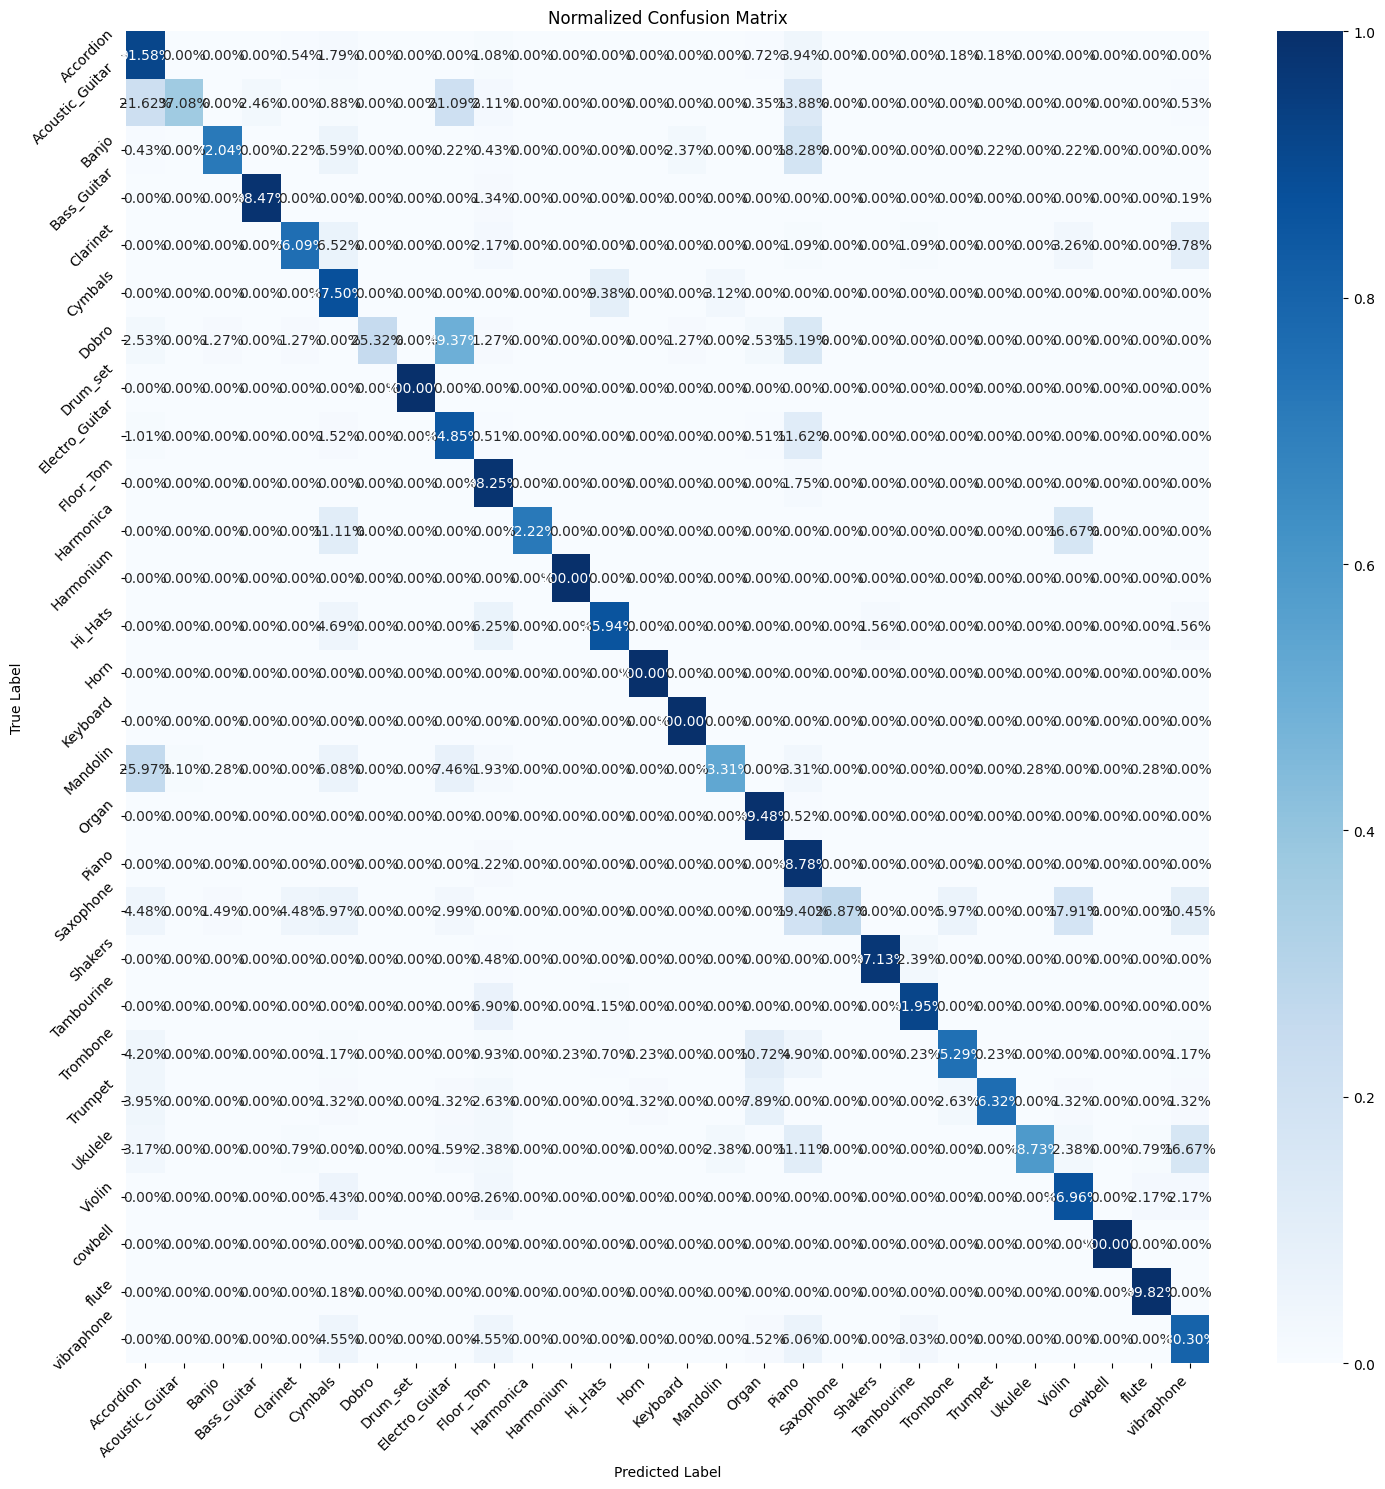


Classification Report:
                 precision    recall  f1-score   support

      Accordion       0.67      0.92      0.77       558
Acoustic_Guitar       0.98      0.37      0.54       569
          Banjo       0.99      0.72      0.83       465
    Bass_Guitar       0.97      0.98      0.98       523
       Clarinet       0.89      0.76      0.82        92
        Cymbals       0.23      0.88      0.36        32
          Dobro       1.00      0.25      0.40        79
       Drum_set       1.00      1.00      1.00       530
 Electro_Guitar       0.47      0.85      0.60       198
      Floor_Tom       0.46      0.98      0.63        57
      Harmonica       1.00      0.72      0.84        18
      Harmonium       0.99      1.00      1.00       194
        Hi_Hats       0.89      0.86      0.87        64
           Horn       0.99      1.00      0.99       188
       Keyboard       0.96      1.00      0.98       291
       Mandolin       0.98      0.53      0.69       362
      

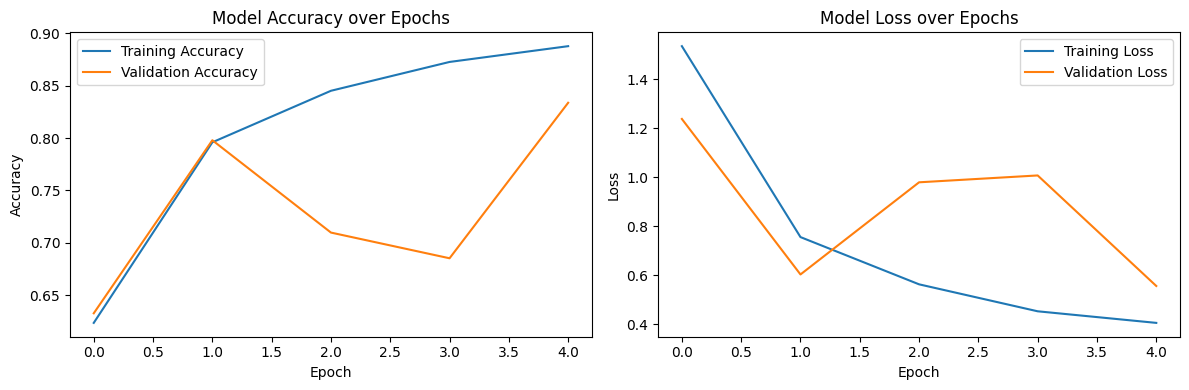

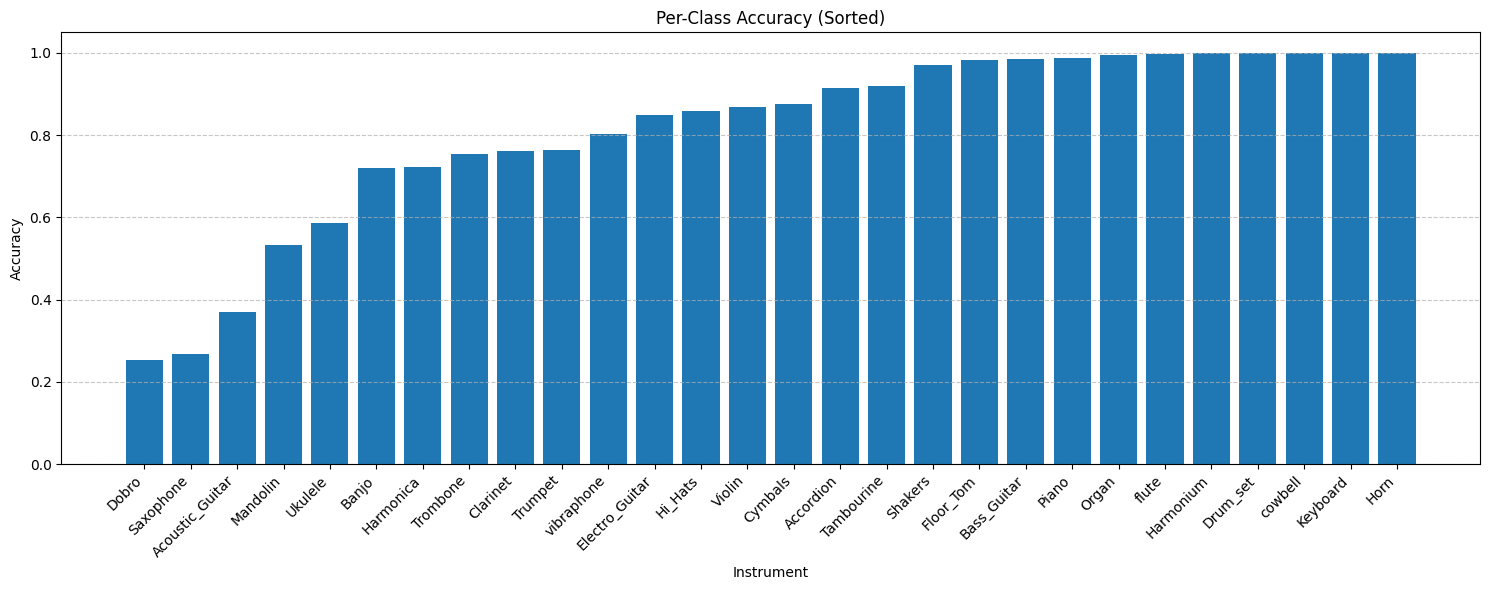


Detailed Performance Analysis:

Top 5 Best Performing Instruments:
Horn: 100.00% accuracy
Keyboard: 100.00% accuracy
cowbell: 100.00% accuracy
Drum_set: 100.00% accuracy
Harmonium: 100.00% accuracy

Top 5 Most Challenging Instruments:
Dobro: 25.32% accuracy
Saxophone: 26.87% accuracy
Acoustic_Guitar: 37.08% accuracy
Mandolin: 53.31% accuracy
Ukulele: 58.73% accuracy


In [ ]:
five_epoch_evaluation = evaluate_model_performance(
    five_epoch_model,
    generator_data_5['test_generator'],
    generator_data_5['test_steps'],
    label_encoder,
    history=five_epoch_history.history
)

## 10 Epoch Evaluation

Evaluating model on test set...
198/198 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.9485 - loss: 0.1816

Test accuracy: 0.9454

Test loss: 0.1855

Generating predictions for detailed analysis...


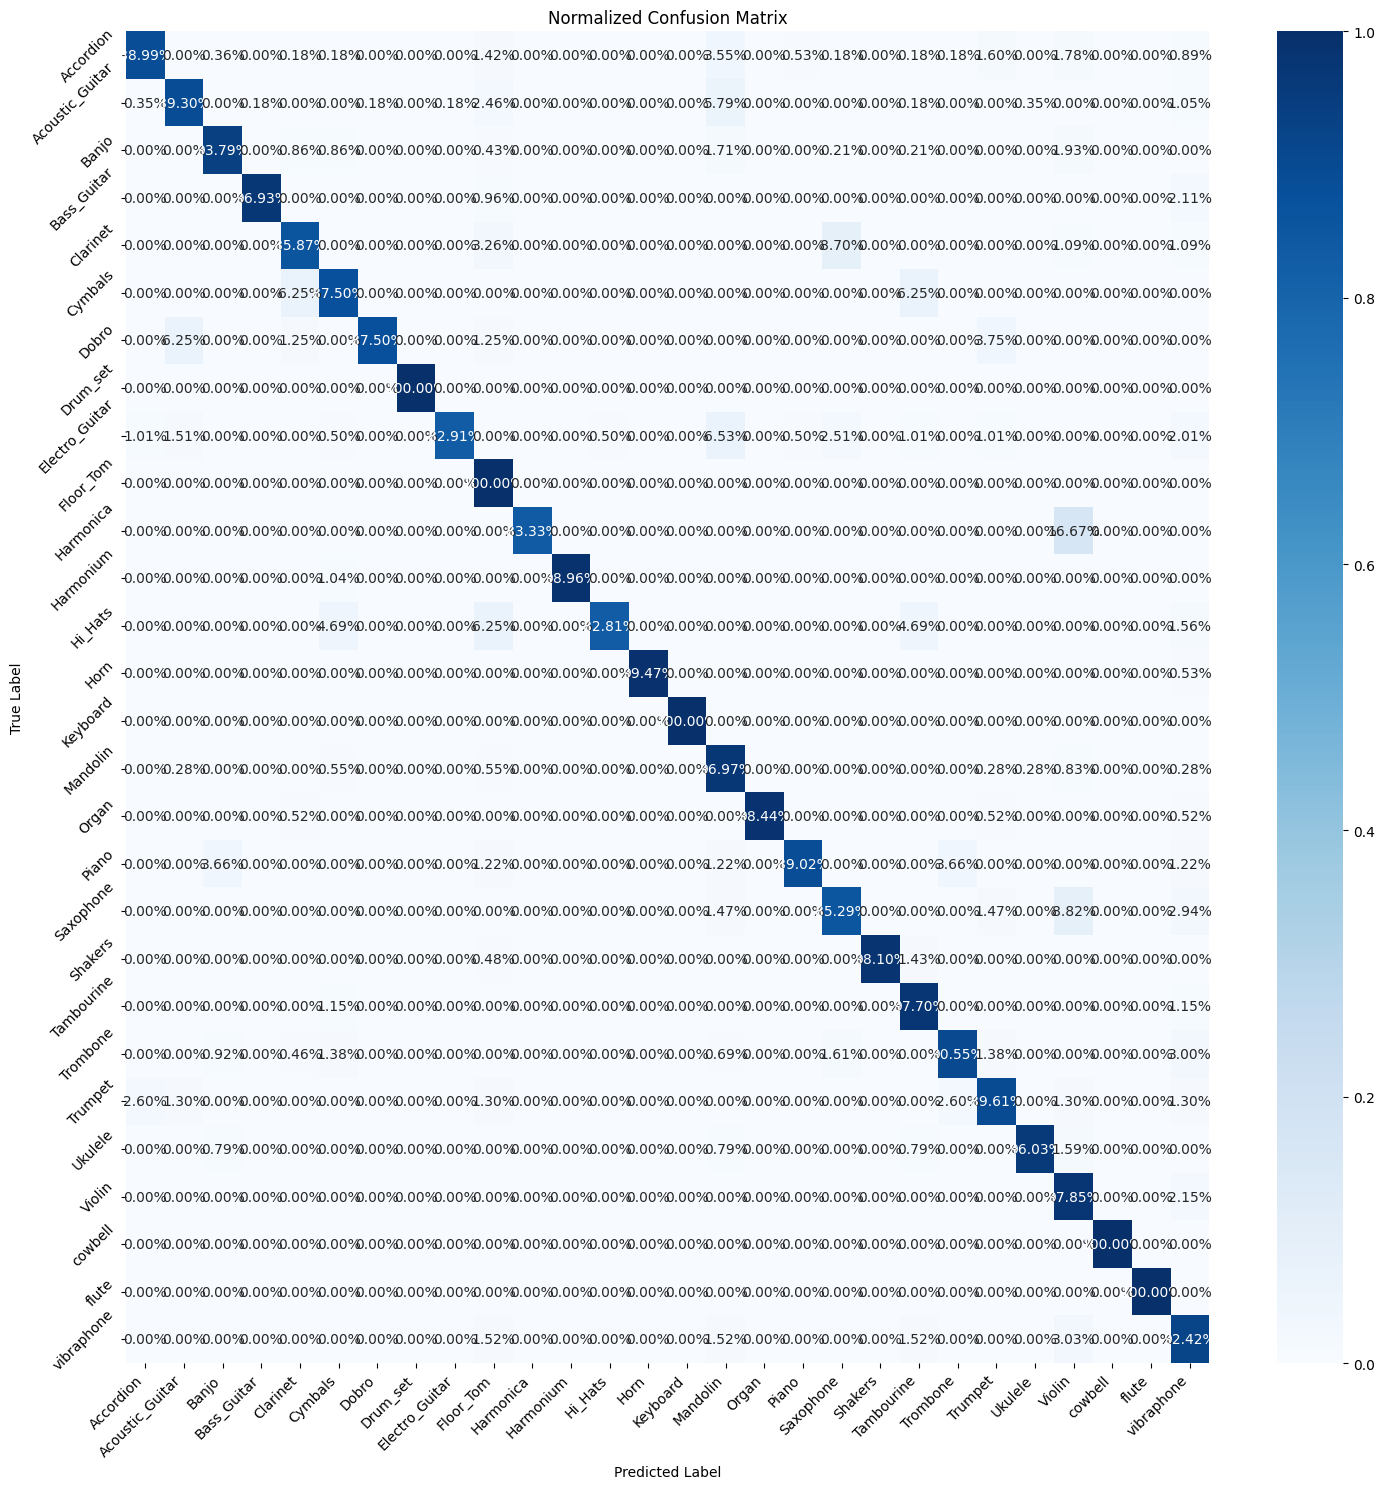


Classification Report:
                 precision    recall  f1-score   support

      Accordion       0.99      0.89      0.94       563
Acoustic_Guitar       0.98      0.89      0.93       570
          Banjo       0.98      0.94      0.96       467
    Bass_Guitar       1.00      0.97      0.98       522
       Clarinet       0.88      0.86      0.87        92
        Cymbals       0.58      0.88      0.70        32
          Dobro       0.99      0.88      0.93        80
       Drum_set       1.00      1.00      1.00       529
 Electro_Guitar       0.99      0.83      0.90       199
      Floor_Tom       0.57      1.00      0.73        57
      Harmonica       1.00      0.83      0.91        18
      Harmonium       1.00      0.99      0.99       193
        Hi_Hats       0.98      0.83      0.90        64
           Horn       1.00      0.99      1.00       189
       Keyboard       1.00      1.00      1.00       290
       Mandolin       0.81      0.97      0.88       363
      

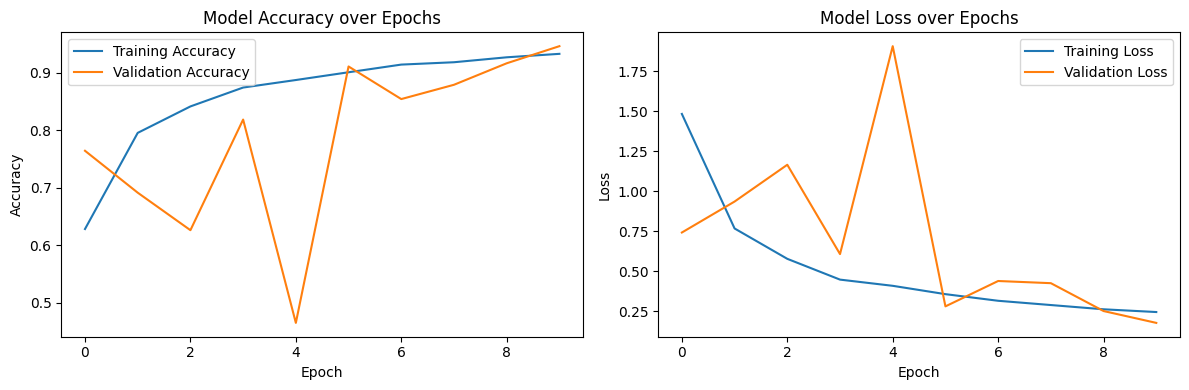

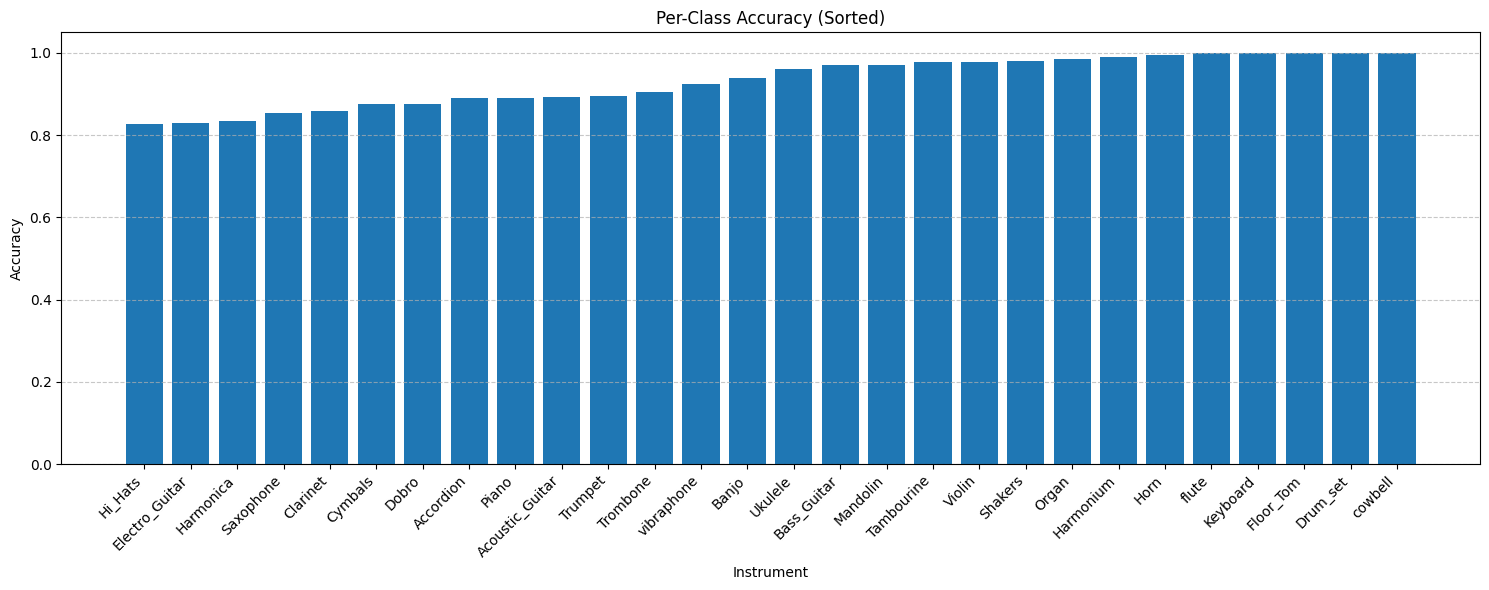


Detailed Performance Analysis:

Top 5 Best Performing Instruments:
cowbell: 100.00% accuracy
Drum_set: 100.00% accuracy
Floor_Tom: 100.00% accuracy
Keyboard: 100.00% accuracy
flute: 100.00% accuracy

Top 5 Most Challenging Instruments:
Hi_Hats: 82.81% accuracy
Electro_Guitar: 82.91% accuracy
Harmonica: 83.33% accuracy
Saxophone: 85.29% accuracy
Clarinet: 85.87% accuracy


In [ ]:
ten_epoch_evaluation = evaluate_model_performance(
    ten_epoch_model,
    generator_data_10['test_generator'],
    generator_data_10['test_steps'],
    label_encoder,
    history=ten_epoch_history.history
)

## 7 Epoch Evaluation

Evaluating model on test set...
198/198 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.9391 - loss: 0.1972

Test accuracy: 0.9392

Test loss: 0.2046

Generating predictions for detailed analysis...


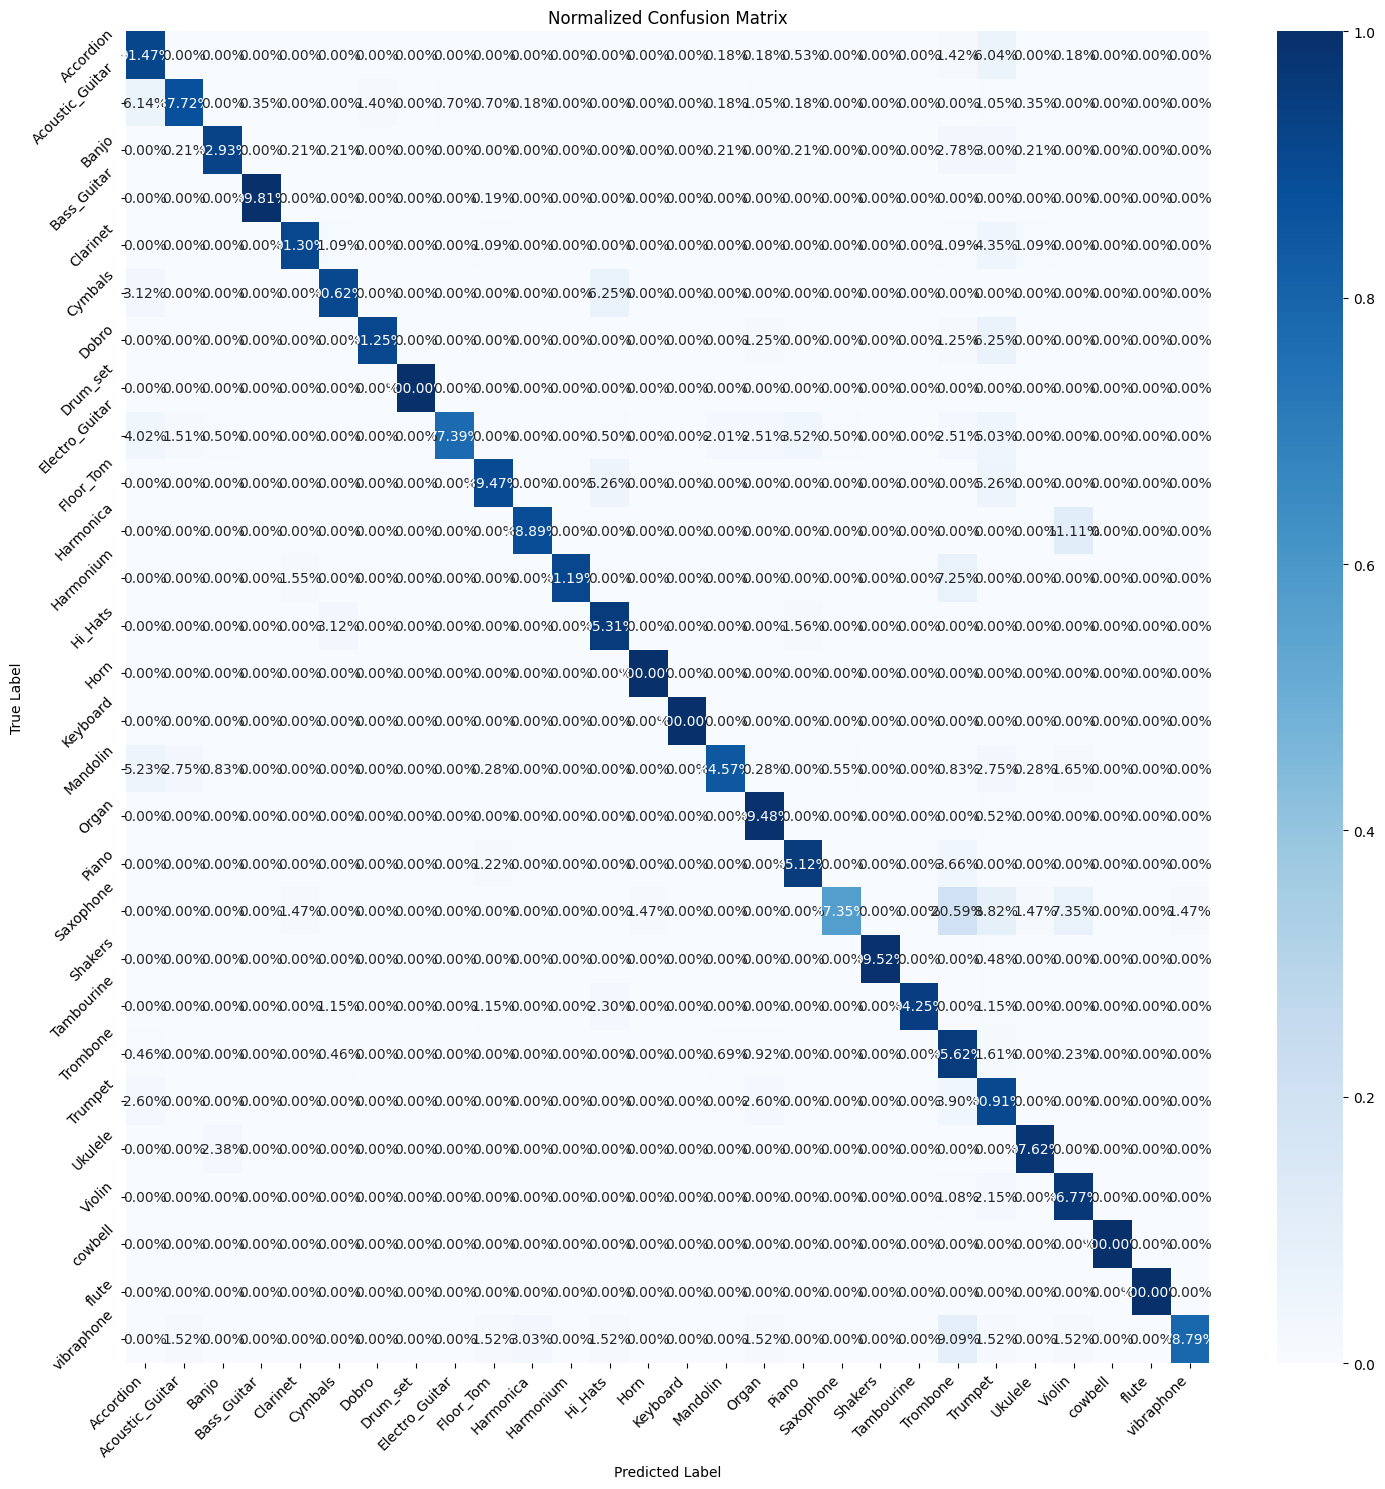


Classification Report:
                 precision    recall  f1-score   support

      Accordion       0.88      0.91      0.90       563
Acoustic_Guitar       0.97      0.88      0.92       570
          Banjo       0.98      0.93      0.96       467
    Bass_Guitar       1.00      1.00      1.00       522
       Clarinet       0.94      0.91      0.93        92
        Cymbals       0.81      0.91      0.85        32
          Dobro       0.90      0.91      0.91        80
       Drum_set       1.00      1.00      1.00       529
 Electro_Guitar       0.97      0.77      0.86       199
      Floor_Tom       0.84      0.89      0.86        57
      Harmonica       0.84      0.89      0.86        18
      Harmonium       1.00      0.91      0.95       193
        Hi_Hats       0.87      0.95      0.91        64
           Horn       0.99      1.00      1.00       189
       Keyboard       1.00      1.00      1.00       290
       Mandolin       0.97      0.85      0.90       363
      

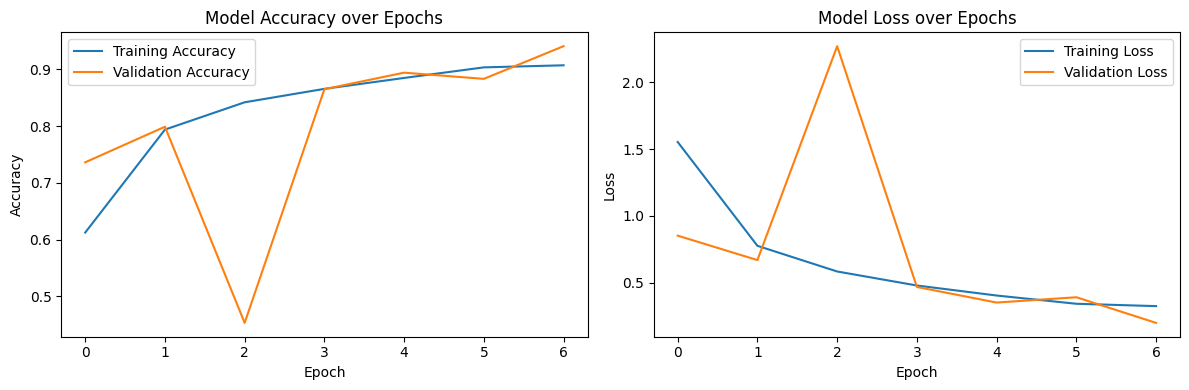

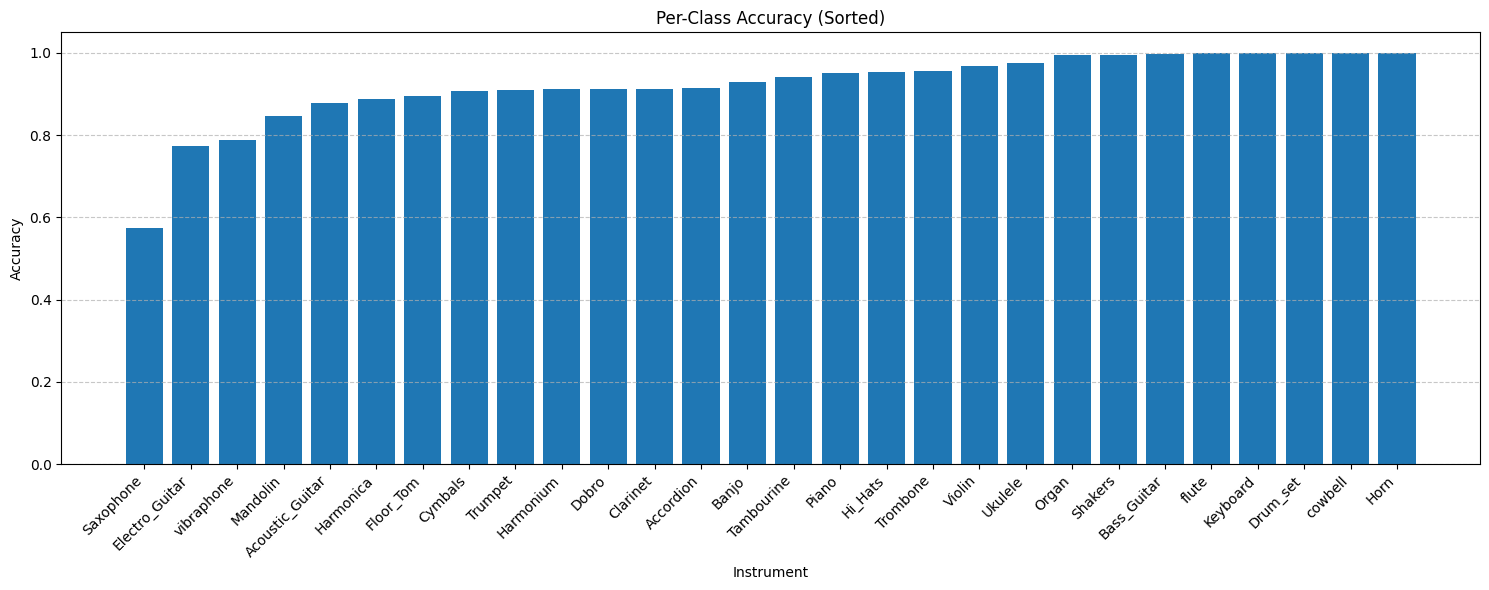


Detailed Performance Analysis:

Top 5 Best Performing Instruments:
Horn: 100.00% accuracy
cowbell: 100.00% accuracy
Drum_set: 100.00% accuracy
Keyboard: 100.00% accuracy
flute: 100.00% accuracy

Top 5 Most Challenging Instruments:
Saxophone: 57.35% accuracy
Electro_Guitar: 77.39% accuracy
vibraphone: 78.79% accuracy
Mandolin: 84.57% accuracy
Acoustic_Guitar: 87.72% accuracy


In [ ]:
seven_epoch_evaluation = evaluate_model_performance(
    seven_epoch_model,
    generator_data_7['test_generator'],
    generator_data_7['test_steps'],
    label_encoder,
    history=seven_epoch_history.history
)

# Faster Testing

In [52]:
def create_simple_test_model(input_shape, num_classes, hyperparameters):
    model = Sequential([
        Input(shape=input_shape),
        
        Conv2D(hyperparameters['filters'][0], (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Dropout(hyperparameters['dropout_rate']),
        
        Conv2D(hyperparameters['filters'][1], (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Dropout(hyperparameters['dropout_rate']),
        
        GlobalAveragePooling2D(),
        
        Dense(hyperparameters['dense_units'], activation='relu'),
        Dropout(0.5),
        
        Dense(num_classes, activation='softmax')
    ])
    
    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=hyperparameters['learning_rate']),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

def quick_test_hyperparameters(file_paths, encoded_labels, hyperparameters, sample_fraction=0.1):
    # Randomly sample a subset of the data
    total_samples = len(file_paths)
    sample_size = int(total_samples * sample_fraction)
    indices = np.random.choice(total_samples, size=sample_size, replace=False)
    
    # Create sampled datasets
    sampled_paths = [file_paths[i] for i in indices]
    sampled_labels = [encoded_labels[i] for i in indices]
    
    # Create train/validation split
    test_splits = create_dataset_splits(sampled_paths)
    
    # Create generators with the sampled data
    generator_data = reset_generators(
        sampled_paths,
        sampled_labels,
        test_splits,
        batch_size=32
    )
    
    # Create and train the model
    sample_spectrogram = np.load(sampled_paths[0])
    input_shape = (*sample_spectrogram.shape, 1)
    
    model = create_simple_test_model(input_shape, num_classes, hyperparameters)
    
    # Train for just a few epochs
    history = model.fit(
        generator_data['train_generator'],
        steps_per_epoch=generator_data['steps_per_epoch'],
        validation_data=generator_data['val_generator'],
        validation_steps=generator_data['validation_steps'],
        epochs=3,
        verbose=1
    )
    
    return {
        'val_accuracy': history.history['val_accuracy'][-1],
        'val_loss': history.history['val_loss'][-1]
    }
    
def train_test_configurations(test_configurations):
    # Test each configuration
    results = []
    for config in test_configurations:
        print(f"\nTesting configuration: {config}")
        config_result = quick_test_hyperparameters(file_paths, encoded_labels, config)
        results.append({
            'config': config,
            'results': config_result
        })
    
    print("~~Results~~~")
    for result in results:
        print(f"config{result['config']}")
        print(f"Validation accuracy: {result['results']['val_accuracy']:.4f}")
        print(f"Validation loss: {result['results']['val_loss']:.4f}")

## Learning Rate

In [53]:
test_configurations = [
    {
        'filters': (32, 64),  
        'dropout_rate': 0.3,  
        'dense_units': 64,
        'learning_rate': 0.001
    },
    {
        'filters': (32, 64),
        'dropout_rate': 0.3,
        'dense_units': 64,
        'learning_rate': 0.0005
    },
    {
        'filters': (32, 64),
        'dropout_rate': 0.3,
        'dense_units': 64,
        'learning_rate': 0.002
    },
    {
        'filters': (32, 64),
        'dropout_rate': 0.3,
        'dense_units': 64,
        'learning_rate': 0.003
    },
    {
        'filters': (32, 64),
        'dropout_rate': 0.3,
        'dense_units': 64,
        'learning_rate': 0.005
    },
]
train_test_configurations(test_configurations)


Testing configuration: {'filters': (32, 64), 'dropout_rate': 0.3, 'dense_units': 64, 'learning_rate': 0.001}
Epoch 1/3
92/92 ━━━━━━━━━━━━━━━━━━━━ 25s 256ms/step - accuracy: 0.0771 - loss: 3.2254 - val_accuracy: 0.0132 - val_loss: 4.5917
Epoch 2/3
92/92 ━━━━━━━━━━━━━━━━━━━━ 23s 253ms/step - accuracy: 0.2423 - loss: 2.7750 - val_accuracy: 0.1445 - val_loss: 3.4090
Epoch 3/3
92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 228ms/step - accuracy: 0.3182 - loss: 2.4724 - val_accuracy: 0.3389 - val_loss: 2.3119

Testing configuration: {'filters': (32, 64), 'dropout_rate': 0.3, 'dense_units': 64, 'learning_rate': 0.0005}
Epoch 1/3
92/92 ━━━━━━━━━━━━━━━━━━━━ 24s 247ms/step - accuracy: 0.0664 - loss: 3.2692 - val_accuracy: 0.0378 - val_loss: 3.5044
Epoch 2/3
92/92 ━━━━━━━━━━━━━━━━━━━━ 22s 244ms/step - accuracy: 0.2002 - loss: 2.9540 - val_accuracy: 0.2076 - val_loss: 2.8158
Epoch 3/3
92/92 ━━━━━━━━━━━━━━━━━━━━ 23s 246ms/step - accuracy: 0.2663 - loss: 2.6389 - val_accuracy: 0.4086 - val_loss: 2.4598

Testing co

## Filter Counts in early layers

In [54]:
test_configurations = [
    {
        'filters': (16, 32),  
        'dropout_rate': 0.3,  
        'dense_units': 64,
        'learning_rate': 0.0005
    },
    {
        'filters': (32, 64),
        'dropout_rate': 0.3,
        'dense_units': 64,
        'learning_rate': 0.0005
    },
    {
        'filters': (64, 128),
        'dropout_rate': 0.3,
        'dense_units': 64,
        'learning_rate': 0.0005
    },
    {
        'filters': (128, 256),
        'dropout_rate': 0.3,
        'dense_units': 64,
        'learning_rate': 0.0005
    },
]

train_test_configurations(test_configurations)


Testing configuration: {'filters': (16, 32), 'dropout_rate': 0.3, 'dense_units': 64, 'learning_rate': 0.0005}
Epoch 1/3
92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 112ms/step - accuracy: 0.0960 - loss: 3.3024 - val_accuracy: 0.0872 - val_loss: 3.3698
Epoch 2/3
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 109ms/step - accuracy: 0.1868 - loss: 3.1915 - val_accuracy: 0.2608 - val_loss: 2.9523
Epoch 3/3
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 108ms/step - accuracy: 0.2532 - loss: 2.8296 - val_accuracy: 0.1944 - val_loss: 2.6894

Testing configuration: {'filters': (32, 64), 'dropout_rate': 0.3, 'dense_units': 64, 'learning_rate': 0.0005}
Epoch 1/3
92/92 ━━━━━━━━━━━━━━━━━━━━ 24s 246ms/step - accuracy: 0.0686 - loss: 3.3807 - val_accuracy: 0.0164 - val_loss: 3.3173
Epoch 2/3
92/92 ━━━━━━━━━━━━━━━━━━━━ 22s 239ms/step - accuracy: 0.2101 - loss: 2.8917 - val_accuracy: 0.1944 - val_loss: 2.8157
Epoch 3/3
92/92 ━━━━━━━━━━━━━━━━━━━━ 22s 239ms/step - accuracy: 0.2766 - loss: 2.5623 - val_accuracy: 0.2326 - val_loss: 2.6100

Testing c

## Dropout Rate in early layers

In [55]:
test_configurations = [
    {
        'filters': (32, 64),  
        'dropout_rate': 0.2,  
        'dense_units': 64,
        'learning_rate': 0.0005
    },
    {
        'filters': (32, 64),
        'dropout_rate': 0.3,
        'dense_units': 64,
        'learning_rate': 0.0005
    },
    {
        'filters': (32, 64),
        'dropout_rate': 0.4,
        'dense_units': 64,
        'learning_rate': 0.0005
    },
    {
        'filters': (32, 64),
        'dropout_rate': 0.5,
        'dense_units': 64,
        'learning_rate': 0.0005
    },
]
train_test_configurations(test_configurations)


Testing configuration: {'filters': (32, 64), 'dropout_rate': 0.2, 'dense_units': 64, 'learning_rate': 0.0005}
Epoch 1/3
92/92 ━━━━━━━━━━━━━━━━━━━━ 24s 251ms/step - accuracy: 0.0593 - loss: 3.2885 - val_accuracy: 0.0707 - val_loss: 3.3649
Epoch 2/3
92/92 ━━━━━━━━━━━━━━━━━━━━ 23s 247ms/step - accuracy: 0.2021 - loss: 2.9128 - val_accuracy: 0.1179 - val_loss: 2.8616
Epoch 3/3
92/92 ━━━━━━━━━━━━━━━━━━━━ 23s 247ms/step - accuracy: 0.2842 - loss: 2.5807 - val_accuracy: 0.2226 - val_loss: 2.6016

Testing configuration: {'filters': (32, 64), 'dropout_rate': 0.3, 'dense_units': 64, 'learning_rate': 0.0005}
Epoch 1/3
92/92 ━━━━━━━━━━━━━━━━━━━━ 26s 269ms/step - accuracy: 0.0651 - loss: 3.2278 - val_accuracy: 0.0082 - val_loss: 3.8417
Epoch 2/3
92/92 ━━━━━━━━━━━━━━━━━━━━ 24s 259ms/step - accuracy: 0.1765 - loss: 2.9169 - val_accuracy: 0.1495 - val_loss: 2.8781
Epoch 3/3
92/92 ━━━━━━━━━━━━━━━━━━━━ 23s 254ms/step - accuracy: 0.2725 - loss: 2.6810 - val_accuracy: 0.3090 - val_loss: 2.4807

Testing c

## Dense Unit Count in Final Dense Layer

In [56]:
test_configurations = [
    {
        'filters': (32, 64),  
        'dropout_rate': 0.2,  
        'dense_units': 32,
        'learning_rate': 0.0005
    },
    {
        'filters': (32, 64),
        'dropout_rate': 0.2,
        'dense_units': 64,
        'learning_rate': 0.0005
    },
    {
        'filters': (32, 64),
        'dropout_rate': 0.2,
        'dense_units': 128,
        'learning_rate': 0.0005
    },
    {
        'filters': (32, 64),
        'dropout_rate': 0.2,
        'dense_units': 256,
        'learning_rate': 0.0005
    },
]
train_test_configurations(test_configurations)


Testing configuration: {'filters': (32, 64), 'dropout_rate': 0.2, 'dense_units': 32, 'learning_rate': 0.0005}
Epoch 1/3
92/92 ━━━━━━━━━━━━━━━━━━━━ 24s 244ms/step - accuracy: 0.0689 - loss: 3.3940 - val_accuracy: 0.0609 - val_loss: 3.4345
Epoch 2/3
92/92 ━━━━━━━━━━━━━━━━━━━━ 23s 249ms/step - accuracy: 0.1746 - loss: 3.0881 - val_accuracy: 0.1528 - val_loss: 3.0417
Epoch 3/3
92/92 ━━━━━━━━━━━━━━━━━━━━ 24s 255ms/step - accuracy: 0.1920 - loss: 2.8783 - val_accuracy: 0.3023 - val_loss: 2.7211

Testing configuration: {'filters': (32, 64), 'dropout_rate': 0.2, 'dense_units': 64, 'learning_rate': 0.0005}
Epoch 1/3
92/92 ━━━━━━━━━━━━━━━━━━━━ 26s 265ms/step - accuracy: 0.0724 - loss: 3.1383 - val_accuracy: 0.0132 - val_loss: 3.9643
Epoch 2/3
92/92 ━━━━━━━━━━━━━━━━━━━━ 24s 262ms/step - accuracy: 0.1803 - loss: 3.0893 - val_accuracy: 0.1495 - val_loss: 2.9258
Epoch 3/3
92/92 ━━━━━━━━━━━━━━━━━━━━ 24s 259ms/step - accuracy: 0.2615 - loss: 2.6754 - val_accuracy: 0.3189 - val_loss: 2.4399

Testing c

In [59]:
def train_optimized_original_model(file_paths, encoded_labels):
    # Create dataset splits
    dataset_splits = create_dataset_splits(file_paths)
    
    generator_data = reset_generators(
        file_paths,
        encoded_labels,
        dataset_splits,
        batch_size=32
    )
    
    sample_spectrogram = np.load(file_paths[0])
    input_shape = (*sample_spectrogram.shape, 1)
    
    model = Sequential([
        Input(shape=input_shape),
        
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((4, 4)),
        BatchNormalization(),
        Dropout(0.25), 
        
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((4, 4)),
        BatchNormalization(),
        Dropout(0.25),
        
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Dropout(0.25),
        
        GlobalAveragePooling2D(),
        
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        
        Dense(num_classes, activation='softmax')
    ])
    
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True,
        verbose=1
    )
    
    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    history = model.fit(
        generator_data['train_generator'],
        steps_per_epoch=generator_data['steps_per_epoch'],
        validation_data=generator_data['val_generator'],
        validation_steps=generator_data['validation_steps'],
        epochs=20,
        callbacks=[early_stopping],
        verbose=1
    )

    return model, history, generator_data

# Run the training
final_model, final_history, final_generator_data = train_optimized_original_model(file_paths, encoded_labels)
final_model.save('Instrument_classifier.keras')

Epoch 1/20
925/925 ━━━━━━━━━━━━━━━━━━━━ 118s 122ms/step - accuracy: 0.4414 - loss: 2.2952 - val_accuracy: 0.6829 - val_loss: 1.0788
Epoch 2/20
925/925 ━━━━━━━━━━━━━━━━━━━━ 128s 138ms/step - accuracy: 0.7375 - loss: 1.0457 - val_accuracy: 0.8244 - val_loss: 0.5880
Epoch 3/20
925/925 ━━━━━━━━━━━━━━━━━━━━ 119s 128ms/step - accuracy: 0.8166 - loss: 0.7046 - val_accuracy: 0.7642 - val_loss: 0.7609
Epoch 4/20
925/925 ━━━━━━━━━━━━━━━━━━━━ 121s 130ms/step - accuracy: 0.8413 - loss: 0.5761 - val_accuracy: 0.8782 - val_loss: 0.3917
Epoch 5/20
925/925 ━━━━━━━━━━━━━━━━━━━━ 120s 130ms/step - accuracy: 0.8678 - loss: 0.4928 - val_accuracy: 0.9116 - val_loss: 0.2920
Epoch 6/20
925/925 ━━━━━━━━━━━━━━━━━━━━ 120s 130ms/step - accuracy: 0.8815 - loss: 0.4435 - val_accuracy: 0.9219 - val_loss: 0.2841
Epoch 7/20
925/925 ━━━━━━━━━━━━━━━━━━━━ 120s 129ms/step - accuracy: 0.8927 - loss: 0.3914 - val_accuracy: 0.9232 - val_loss: 0.2636
Epoch 8/20
925/925 ━━━━━━━━━━━━━━━━━━━━ 120s 130ms/step - accuracy: 0.9036 -

In [15]:
final_history.history

{'accuracy': [0.5961824059486389,
  0.7834713459014893,
  0.8352881669998169,
  0.8605374097824097,
  0.8838262557983398,
  0.8958593606948853,
  0.9107655882835388,
  0.9141795039176941,
  0.9224268794059753,
  0.9285448789596558,
  0.9363867044448853,
  0.9396991729736328,
  0.9411864280700684,
  0.9441608786582947,
  0.9582558870315552,
  0.9648808240890503,
  0.9659624695777893,
  0.9678553342819214,
  0.9693087935447693,
  0.9695453643798828],
 'loss': [1.6157346963882446,
  0.816126823425293,
  0.6134397983551025,
  0.5250558257102966,
  0.41023680567741394,
  0.38789311051368713,
  0.33190295100212097,
  0.31001025438308716,
  0.27900230884552,
  0.25943702459335327,
  0.22779522836208344,
  0.22035473585128784,
  0.20543619990348816,
  0.19925662875175476,
  0.13634684681892395,
  0.11410996317863464,
  0.10658338665962219,
  0.10265721380710602,
  0.10030101984739304,
  0.09510940313339233],
 'val_accuracy': [0.7462121248245239,
  0.8641114830970764,
  0.8449477553367615,
  0.

Evaluating model on test set...
198/198 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.9804 - loss: 0.0713

Test accuracy: 0.9787

Test loss: 0.0750

Generating predictions for detailed analysis...


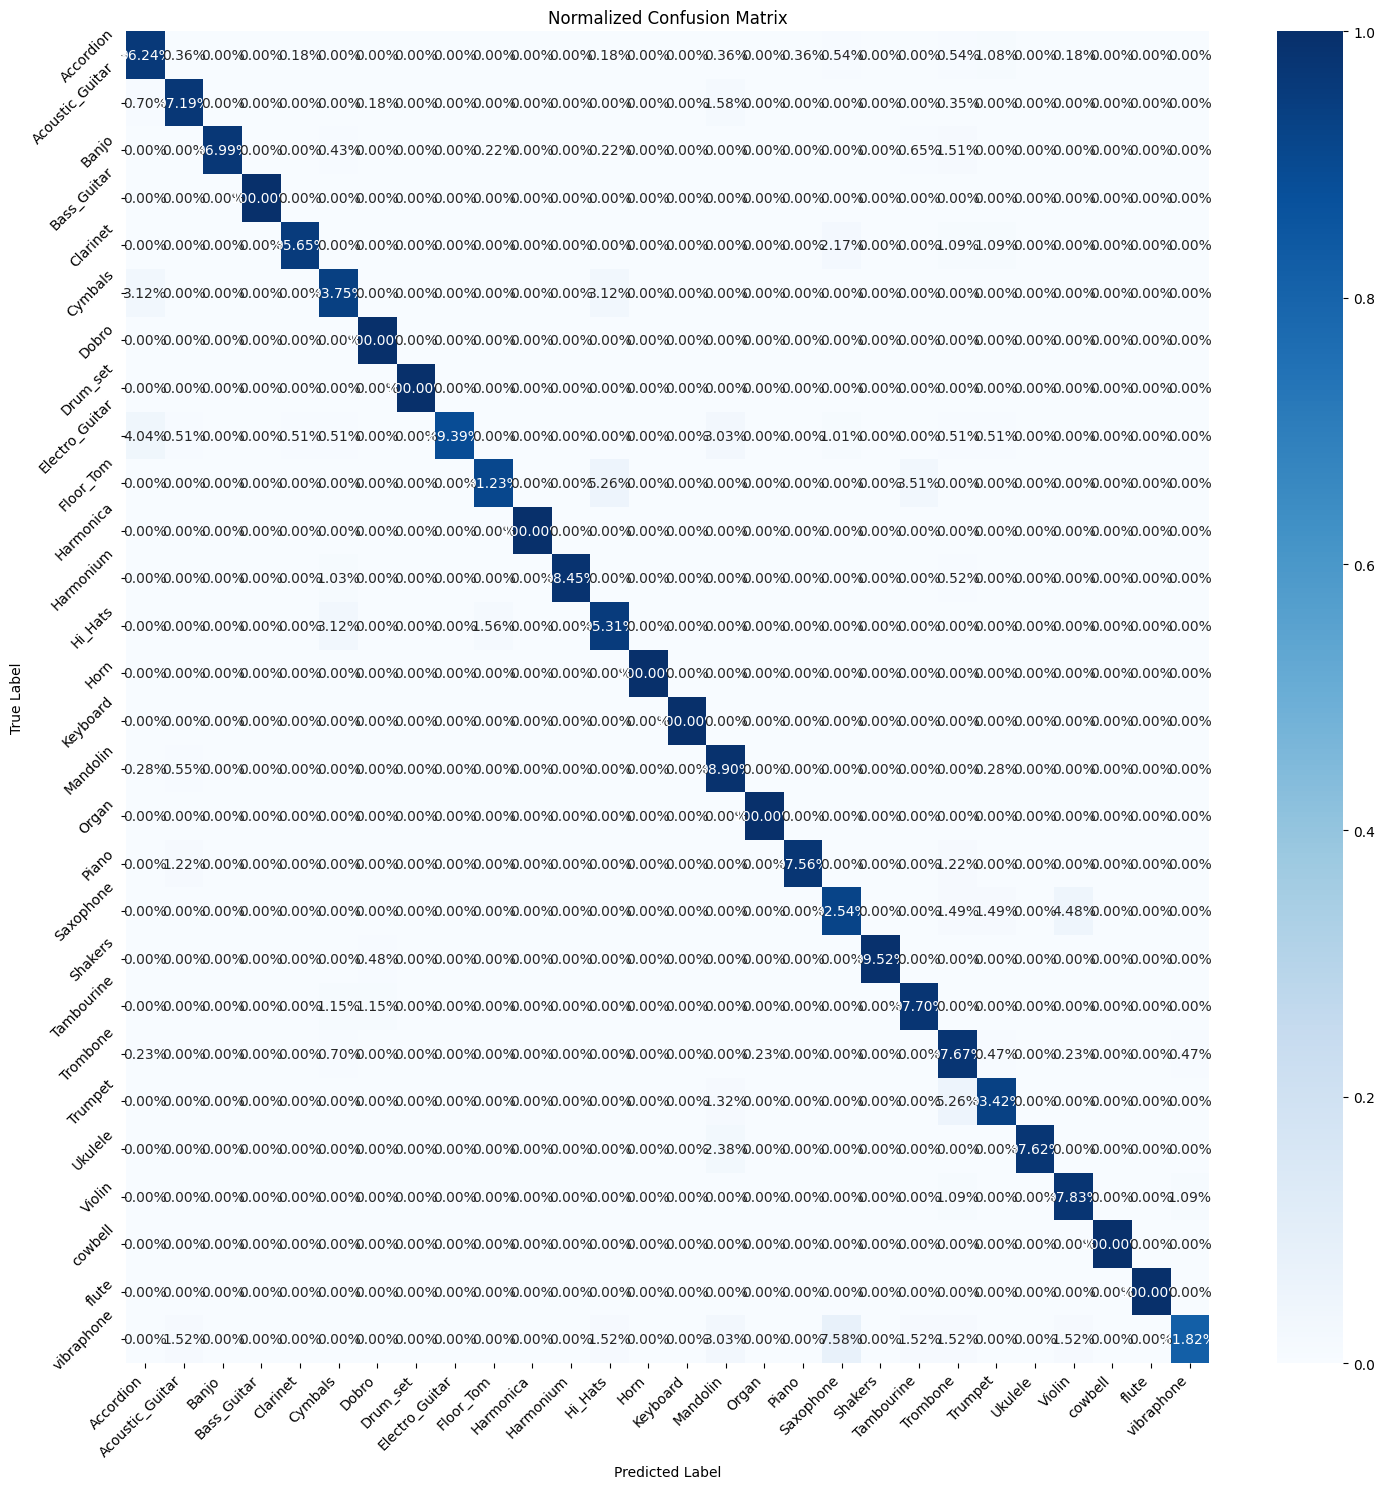


Classification Report:
                 precision    recall  f1-score   support

      Accordion       0.97      0.96      0.97       558
Acoustic_Guitar       0.99      0.97      0.98       569
          Banjo       1.00      0.97      0.98       465
    Bass_Guitar       1.00      1.00      1.00       523
       Clarinet       0.98      0.96      0.97        92
        Cymbals       0.73      0.94      0.82        32
          Dobro       0.96      1.00      0.98        79
       Drum_set       1.00      1.00      1.00       530
 Electro_Guitar       1.00      0.89      0.94       198
      Floor_Tom       0.96      0.91      0.94        57
      Harmonica       1.00      1.00      1.00        18
      Harmonium       1.00      0.98      0.99       194
        Hi_Hats       0.90      0.95      0.92        64
           Horn       1.00      1.00      1.00       188
       Keyboard       1.00      1.00      1.00       291
       Mandolin       0.94      0.99      0.96       362
      

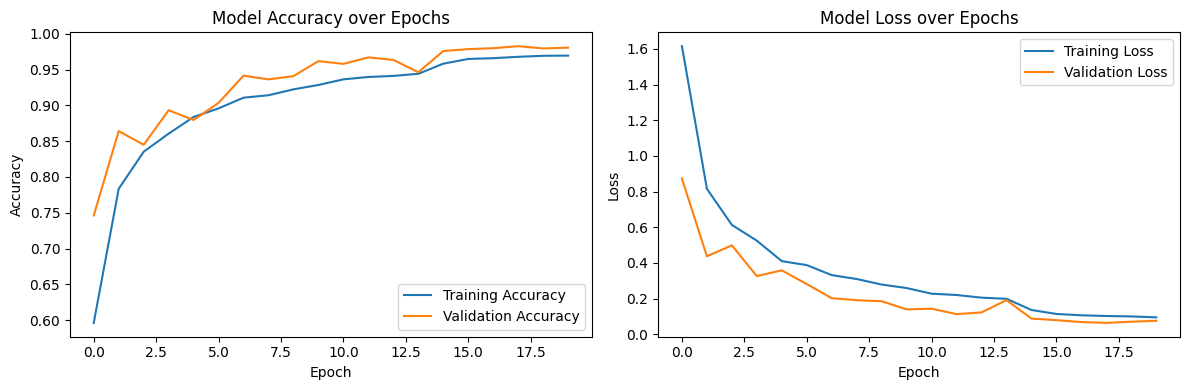

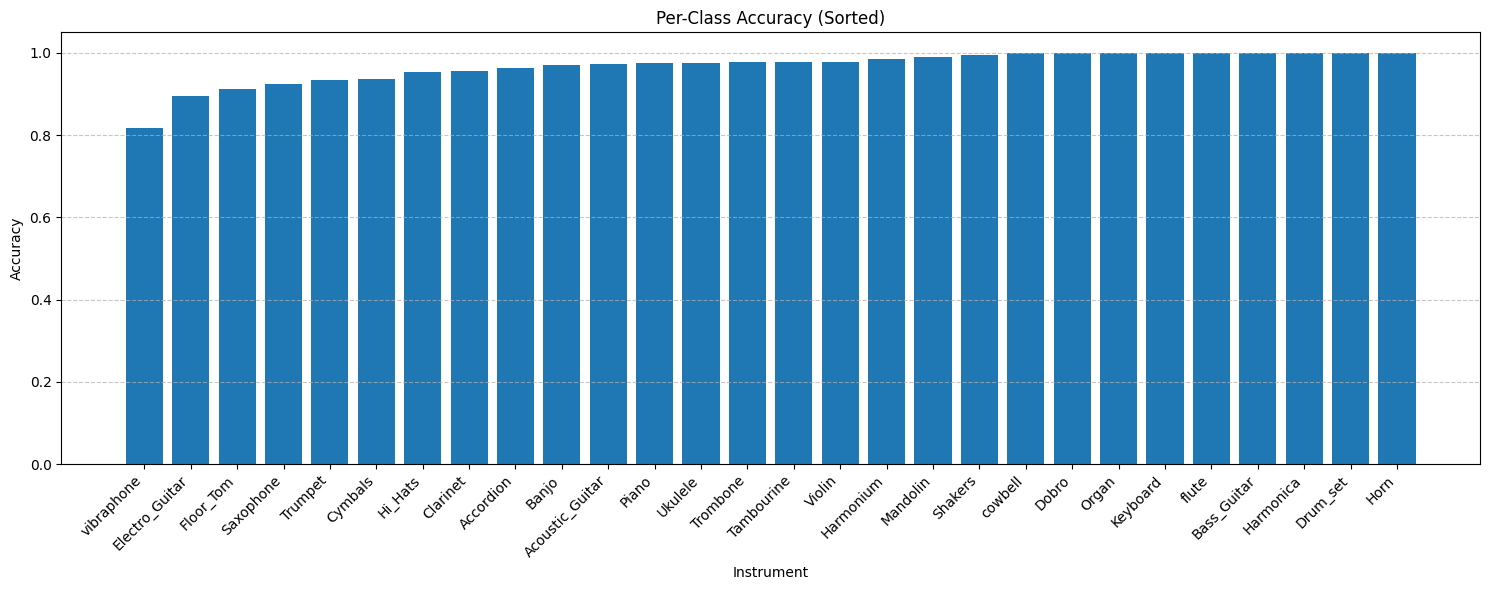


Detailed Performance Analysis:

Top 5 Best Performing Instruments:
Horn: 100.00% accuracy
Drum_set: 100.00% accuracy
Harmonica: 100.00% accuracy
Bass_Guitar: 100.00% accuracy
flute: 100.00% accuracy

Top 5 Most Challenging Instruments:
vibraphone: 81.82% accuracy
Electro_Guitar: 89.39% accuracy
Floor_Tom: 91.23% accuracy
Saxophone: 92.54% accuracy
Trumpet: 93.42% accuracy


In [ ]:
final_evaluation = evaluate_model_performance(
    final_model,
    final_generator_data['test_generator'],
    final_generator_data['test_steps'],
    label_encoder,
    history=final_history.history
)

Since the training accuracy is lower than the validation and test accuracy, it indicates that my model is underfitting. The model architecture above has relatively high dropout rates and BatchNormalization before every layer, so I'll try reducing the dropout rates in the early layers and drop the initial batchnormalization before the first layer to see how that affects model performance.

In [ ]:
# Create dataset splits
dataset_splits = create_dataset_splits(file_paths)

generator_data = reset_generators(
    file_paths,
    encoded_labels,
    dataset_splits,
    batch_size=32
)

sample_spectrogram = np.load(file_paths[0])
input_shape = (*sample_spectrogram.shape, 1)

model = Sequential([
    Input(shape=input_shape),
    
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((4, 4)),
    BatchNormalization(),
    Dropout(0.1),
    
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((4, 4)),
    BatchNormalization(),
    Dropout(0.15),
    
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Dropout(0.2),
    
    GlobalAveragePooling2D(),
    
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(num_classes, activation='softmax')
])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    generator_data['train_generator'],
    steps_per_epoch=generator_data['steps_per_epoch'],
    validation_data=generator_data['val_generator'],
    validation_steps=generator_data['validation_steps'],
    epochs=20,
    callbacks=[early_stopping],
    verbose=1
)

history.history

Epoch 1/20
925/925 ━━━━━━━━━━━━━━━━━━━━ 110s 114ms/step - accuracy: 0.5644 - loss: 1.7846 - val_accuracy: 0.7880 - val_loss: 0.6854
Epoch 2/20
925/925 ━━━━━━━━━━━━━━━━━━━━ 102s 110ms/step - accuracy: 0.8279 - loss: 0.6520 - val_accuracy: 0.8796 - val_loss: 0.4177
Epoch 3/20
925/925 ━━━━━━━━━━━━━━━━━━━━ 110s 119ms/step - accuracy: 0.8832 - loss: 0.4554 - val_accuracy: 0.8735 - val_loss: 0.4082
Epoch 4/20
925/925 ━━━━━━━━━━━━━━━━━━━━ 113s 122ms/step - accuracy: 0.9103 - loss: 0.3295 - val_accuracy: 0.8166 - val_loss: 0.5941
Epoch 5/20
925/925 ━━━━━━━━━━━━━━━━━━━━ 115s 124ms/step - accuracy: 0.9217 - loss: 0.2828 - val_accuracy: 0.8761 - val_loss: 0.3635
Epoch 6/20
925/925 ━━━━━━━━━━━━━━━━━━━━ 114s 123ms/step - accuracy: 0.9364 - loss: 0.2303 - val_accuracy: 0.9278 - val_loss: 0.2584
Epoch 7/20
925/925 ━━━━━━━━━━━━━━━━━━━━ 113s 122ms/step - accuracy: 0.9389 - loss: 0.2240 - val_accuracy: 0.8733 - val_loss: 0.4189
Epoch 8/20
925/925 ━━━━━━━━━━━━━━━━━━━━ 113s 123ms/step - accuracy: 0.9455 -

{'accuracy': [0.6937500238418579,
  0.8437383770942688,
  0.8883556127548218,
  0.914111852645874,
  0.9238465428352356,
  0.936048686504364,
  0.9416934251785278,
  0.9478790163993835,
  0.9536251425743103,
  0.955822229385376,
  0.9597092866897583,
  0.9617373943328857,
  0.9664694666862488],
 'loss': [1.2388842105865479,
  0.5893738269805908,
  0.42716965079307556,
  0.32519349455833435,
  0.27901366353034973,
  0.23672132194042206,
  0.21589155495166779,
  0.19247227907180786,
  0.17022283375263214,
  0.1536361277103424,
  0.13964983820915222,
  0.14416275918483734,
  0.11770685017108917],
 'val_accuracy': [0.7880366444587708,
  0.8796325922012329,
  0.873455822467804,
  0.8165980577468872,
  0.8761482238769531,
  0.9277795553207397,
  0.8732974529266357,
  0.938549280166626,
  0.8750395774841309,
  0.9564459919929504,
  0.9231865406036377,
  0.8873931169509888,
  0.9295216798782349],
 'val_loss': [0.6853840351104736,
  0.41771408915519714,
  0.40816980600357056,
  0.59413003921508

The above changes significantly reduced the validation scores, so I'm going to modify the architecture less. I'm going to try increasing dense unit count in the last layer to see if it will fit better to the data set while still generalizing well.

In [ ]:
# Create dataset splits
dataset_splits = create_dataset_splits(file_paths)

generator_data = reset_generators(
    file_paths,
    encoded_labels,
    dataset_splits,
    batch_size=32
)

sample_spectrogram = np.load(file_paths[0])
input_shape = (*sample_spectrogram.shape, 1)

model = Sequential([
    Input(shape=input_shape),
    
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((4, 4)),
    BatchNormalization(),
    Dropout(0.25),
    
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((4, 4)),
    BatchNormalization(),
    Dropout(0.25),
    
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Dropout(0.25),
    
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),  # Increased neurons
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(num_classes, activation='softmax')
])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    generator_data['train_generator'],
    steps_per_epoch=generator_data['steps_per_epoch'],
    validation_data=generator_data['val_generator'],
    validation_steps=generator_data['validation_steps'],
    epochs=20,
    callbacks=[early_stopping],
    verbose=1
)

history.history

Epoch 1/20
925/925 ━━━━━━━━━━━━━━━━━━━━ 118s 125ms/step - accuracy: 0.4708 - loss: 2.2061 - val_accuracy: 0.5655 - val_loss: 1.2780
Epoch 2/20
925/925 ━━━━━━━━━━━━━━━━━━━━ 120s 129ms/step - accuracy: 0.7609 - loss: 0.9230 - val_accuracy: 0.6527 - val_loss: 1.0455
Epoch 3/20
925/925 ━━━━━━━━━━━━━━━━━━━━ 120s 129ms/step - accuracy: 0.8359 - loss: 0.6066 - val_accuracy: 0.7939 - val_loss: 0.6315
Epoch 4/20
925/925 ━━━━━━━━━━━━━━━━━━━━ 120s 130ms/step - accuracy: 0.8702 - loss: 0.4827 - val_accuracy: 0.8565 - val_loss: 0.4316
Epoch 5/20
925/925 ━━━━━━━━━━━━━━━━━━━━ 120s 130ms/step - accuracy: 0.8900 - loss: 0.4070 - val_accuracy: 0.8863 - val_loss: 0.3689
Epoch 6/20
925/925 ━━━━━━━━━━━━━━━━━━━━ 120s 130ms/step - accuracy: 0.9025 - loss: 0.3395 - val_accuracy: 0.9273 - val_loss: 0.2557
Epoch 7/20
925/925 ━━━━━━━━━━━━━━━━━━━━ 120s 130ms/step - accuracy: 0.9115 - loss: 0.3272 - val_accuracy: 0.9108 - val_loss: 0.2760
Epoch 8/20
925/925 ━━━━━━━━━━━━━━━━━━━━ 120s 130ms/step - accuracy: 0.9236 -

{'accuracy': [0.5964189171791077,
  0.7844516038894653,
  0.8402230739593506,
  0.8706777095794678,
  0.8916342854499817,
  0.9050532579421997,
  0.9156666994094849,
  0.922629714012146,
  0.9306067228317261,
  0.9353726506233215,
  0.939056932926178,
  0.9443299174308777,
  0.9456481337547302,
  0.9518337249755859,
  0.9542673826217651,
  0.9572080373764038,
  0.9562616348266602,
  0.9582220911979675,
  0.9633598327636719,
  0.9622105956077576],
 'loss': [1.6149110794067383,
  0.8278363943099976,
  0.6036741733551025,
  0.4897564947605133,
  0.40704843401908875,
  0.34419333934783936,
  0.3111215829849243,
  0.28874385356903076,
  0.2601812481880188,
  0.2361731380224228,
  0.22232289612293243,
  0.2043502926826477,
  0.19175684452056885,
  0.16797029972076416,
  0.16339047253131866,
  0.15811307728290558,
  0.15706828236579895,
  0.14147935807704926,
  0.12462218105792999,
  0.13416291773319244],
 'val_accuracy': [0.5654987096786499,
  0.6526765823364258,
  0.7939499616622925,
  0.85

In [ ]:
# Create dataset splits
dataset_splits = create_dataset_splits(file_paths)

generator_data = reset_generators(
    file_paths,
    encoded_labels,
    dataset_splits,
    batch_size=32
)

sample_spectrogram = np.load(file_paths[0])
input_shape = (*sample_spectrogram.shape, 1)

model = Sequential([
    Input(shape=input_shape),
    
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((4, 4)),
    BatchNormalization(),
    Dropout(0.25),
    
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((4, 4)),
    BatchNormalization(),
    Dropout(0.25),
    
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Dropout(0.3),
    
    GlobalAveragePooling2D(),
    
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(num_classes, activation='softmax')
])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    generator_data['train_generator'],
    steps_per_epoch=generator_data['steps_per_epoch'],
    validation_data=generator_data['val_generator'],
    validation_steps=generator_data['validation_steps'],
    epochs=20,
    callbacks=[early_stopping],
    verbose=1
)

history.history

Epoch 1/20
925/925 ━━━━━━━━━━━━━━━━━━━━ 226s 242ms/step - accuracy: 0.3614 - loss: 2.6539 - val_accuracy: 0.6509 - val_loss: 1.1533
Epoch 2/20
925/925 ━━━━━━━━━━━━━━━━━━━━ 236s 256ms/step - accuracy: 0.6809 - loss: 1.2389 - val_accuracy: 0.7544 - val_loss: 0.8087
Epoch 3/20
925/925 ━━━━━━━━━━━━━━━━━━━━ 237s 256ms/step - accuracy: 0.7710 - loss: 0.8820 - val_accuracy: 0.2863 - val_loss: 2.9117
Epoch 4/20
925/925 ━━━━━━━━━━━━━━━━━━━━ 237s 256ms/step - accuracy: 0.8187 - loss: 0.6720 - val_accuracy: 0.6680 - val_loss: 0.9429
Epoch 5/20
925/925 ━━━━━━━━━━━━━━━━━━━━ 238s 257ms/step - accuracy: 0.8475 - loss: 0.5565 - val_accuracy: 0.5238 - val_loss: 1.6755
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.


{'accuracy': [0.4992229640483856,
  0.7095825672149658,
  0.7846543788909912,
  0.8262633085250854,
  0.8538786768913269],
 'loss': [2.035228967666626,
  1.1173808574676514,
  0.8200828433036804,
  0.6417142748832703,
  0.5333418250083923],
 'val_accuracy': [0.6508838534355164,
  0.7543553709983826,
  0.28634780645370483,
  0.6680392622947693,
  0.523756742477417],
 'val_loss': [1.1532988548278809,
  0.8087045550346375,
  2.911694049835205,
  0.942900538444519,
  1.6755427122116089]}

After attempting to add a second dense layer at the bottom of the network, it was drastically overfitting. The architecture before this one was better for this task. Testing if removing the initial batch normalization reduces the previous underfitting issue.

In [64]:
# Create dataset splits
dataset_splits = create_dataset_splits(file_paths)

generator_data = reset_generators(
    file_paths,
    encoded_labels,
    dataset_splits,
    batch_size=32
)

sample_spectrogram = np.load(file_paths[0])
input_shape = (*sample_spectrogram.shape, 1)

model = Sequential([
    Input(shape=input_shape),
    
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((4, 4)),
    BatchNormalization(),
    Dropout(0.25),
    
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((4, 4)),
    BatchNormalization(),
    Dropout(0.25),
    
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Dropout(0.25),
    
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(num_classes, activation='softmax')
])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    generator_data['train_generator'],
    steps_per_epoch=generator_data['steps_per_epoch'],
    validation_data=generator_data['val_generator'],
    validation_steps=generator_data['validation_steps'],
    epochs=20,
    callbacks=[early_stopping],
    verbose=1
)

history.history

Epoch 1/20
925/925 ━━━━━━━━━━━━━━━━━━━━ 106s 112ms/step - accuracy: 0.4722 - loss: 2.2403 - val_accuracy: 0.5210 - val_loss: 1.3497
Epoch 2/20
925/925 ━━━━━━━━━━━━━━━━━━━━ 109s 117ms/step - accuracy: 0.7664 - loss: 0.8981 - val_accuracy: 0.7589 - val_loss: 0.7566
Epoch 3/20
925/925 ━━━━━━━━━━━━━━━━━━━━ 114s 123ms/step - accuracy: 0.8278 - loss: 0.6346 - val_accuracy: 0.4948 - val_loss: 2.0414
Epoch 4/20
925/925 ━━━━━━━━━━━━━━━━━━━━ 114s 123ms/step - accuracy: 0.8644 - loss: 0.4860 - val_accuracy: 0.7434 - val_loss: 0.8279
Epoch 5/20
925/925 ━━━━━━━━━━━━━━━━━━━━ 114s 123ms/step - accuracy: 0.8826 - loss: 0.4251 - val_accuracy: 0.6500 - val_loss: 1.4483
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.


{'accuracy': [0.6006081104278564,
  0.7866148352622986,
  0.8377218246459961,
  0.8700016736984253,
  0.8883217573165894],
 'loss': [1.638580083847046,
  0.8112195134162903,
  0.6117134690284729,
  0.47660019993782043,
  0.405201256275177],
 'val_accuracy': [0.5209911465644836,
  0.7589483857154846,
  0.4947735071182251,
  0.7434272766113281,
  0.6499841809272766],
 'val_loss': [1.3497284650802612,
  0.7566091418266296,
  2.0414230823516846,
  0.8278516530990601,
  1.4482532739639282]}

Removing the initial BatchNormalization Layer was really detrimental to model performance. Below, I retrain the best performing model and run evals on it. This will be my final model.

In [ ]:
# Create dataset splits
dataset_splits = create_dataset_splits(file_paths)

generator_data = reset_generators(
    file_paths,
    encoded_labels,
    dataset_splits,
    batch_size=32
)

sample_spectrogram = np.load(file_paths[0])
input_shape = (*sample_spectrogram.shape, 1)

best_model = Sequential([
    Input(shape=input_shape),
    
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((4, 4)),
    BatchNormalization(),
    Dropout(0.25),
    
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((4, 4)),
    BatchNormalization(),
    Dropout(0.25),
    
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Dropout(0.25),
    
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(num_classes, activation='softmax')
])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

best_model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = best_model.fit(
    generator_data['train_generator'],
    steps_per_epoch=generator_data['steps_per_epoch'],
    validation_data=generator_data['val_generator'],
    validation_steps=generator_data['validation_steps'],
    epochs=20,
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/20
925/925 ━━━━━━━━━━━━━━━━━━━━ 113s 119ms/step - accuracy: 0.4891 - loss: 2.1586 - val_accuracy: 0.5538 - val_loss: 1.3598
Epoch 2/20
925/925 ━━━━━━━━━━━━━━━━━━━━ 115s 125ms/step - accuracy: 0.7588 - loss: 0.9200 - val_accuracy: 0.7084 - val_loss: 0.9697
Epoch 3/20
925/925 ━━━━━━━━━━━━━━━━━━━━ 120s 130ms/step - accuracy: 0.8221 - loss: 0.6544 - val_accuracy: 0.7962 - val_loss: 0.6169
Epoch 4/20
925/925 ━━━━━━━━━━━━━━━━━━━━ 120s 130ms/step - accuracy: 0.8635 - loss: 0.4821 - val_accuracy: 0.8630 - val_loss: 0.4369
Epoch 5/20
925/925 ━━━━━━━━━━━━━━━━━━━━ 121s 130ms/step - accuracy: 0.8836 - loss: 0.4308 - val_accuracy: 0.8866 - val_loss: 0.3957
Epoch 6/20
925/925 ━━━━━━━━━━━━━━━━━━━━ 120s 130ms/step - accuracy: 0.8968 - loss: 0.3772 - val_accuracy: 0.8731 - val_loss: 0.3704
Epoch 7/20
925/925 ━━━━━━━━━━━━━━━━━━━━ 120s 130ms/step - accuracy: 0.9098 - loss: 0.3277 - val_accuracy: 0.9292 - val_loss: 0.2268
Epoch 8/20
925/925 ━━━━━━━━━━━━━━━━━━━━ 121s 130ms/step - accuracy: 0.9207 -

NameError: name 'evaluate_model_performance' is not defined

Evaluating model on test set...
198/198 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.9672 - loss: 0.1209

Test accuracy: 0.9634

Test loss: 0.1295

Generating predictions for detailed analysis...


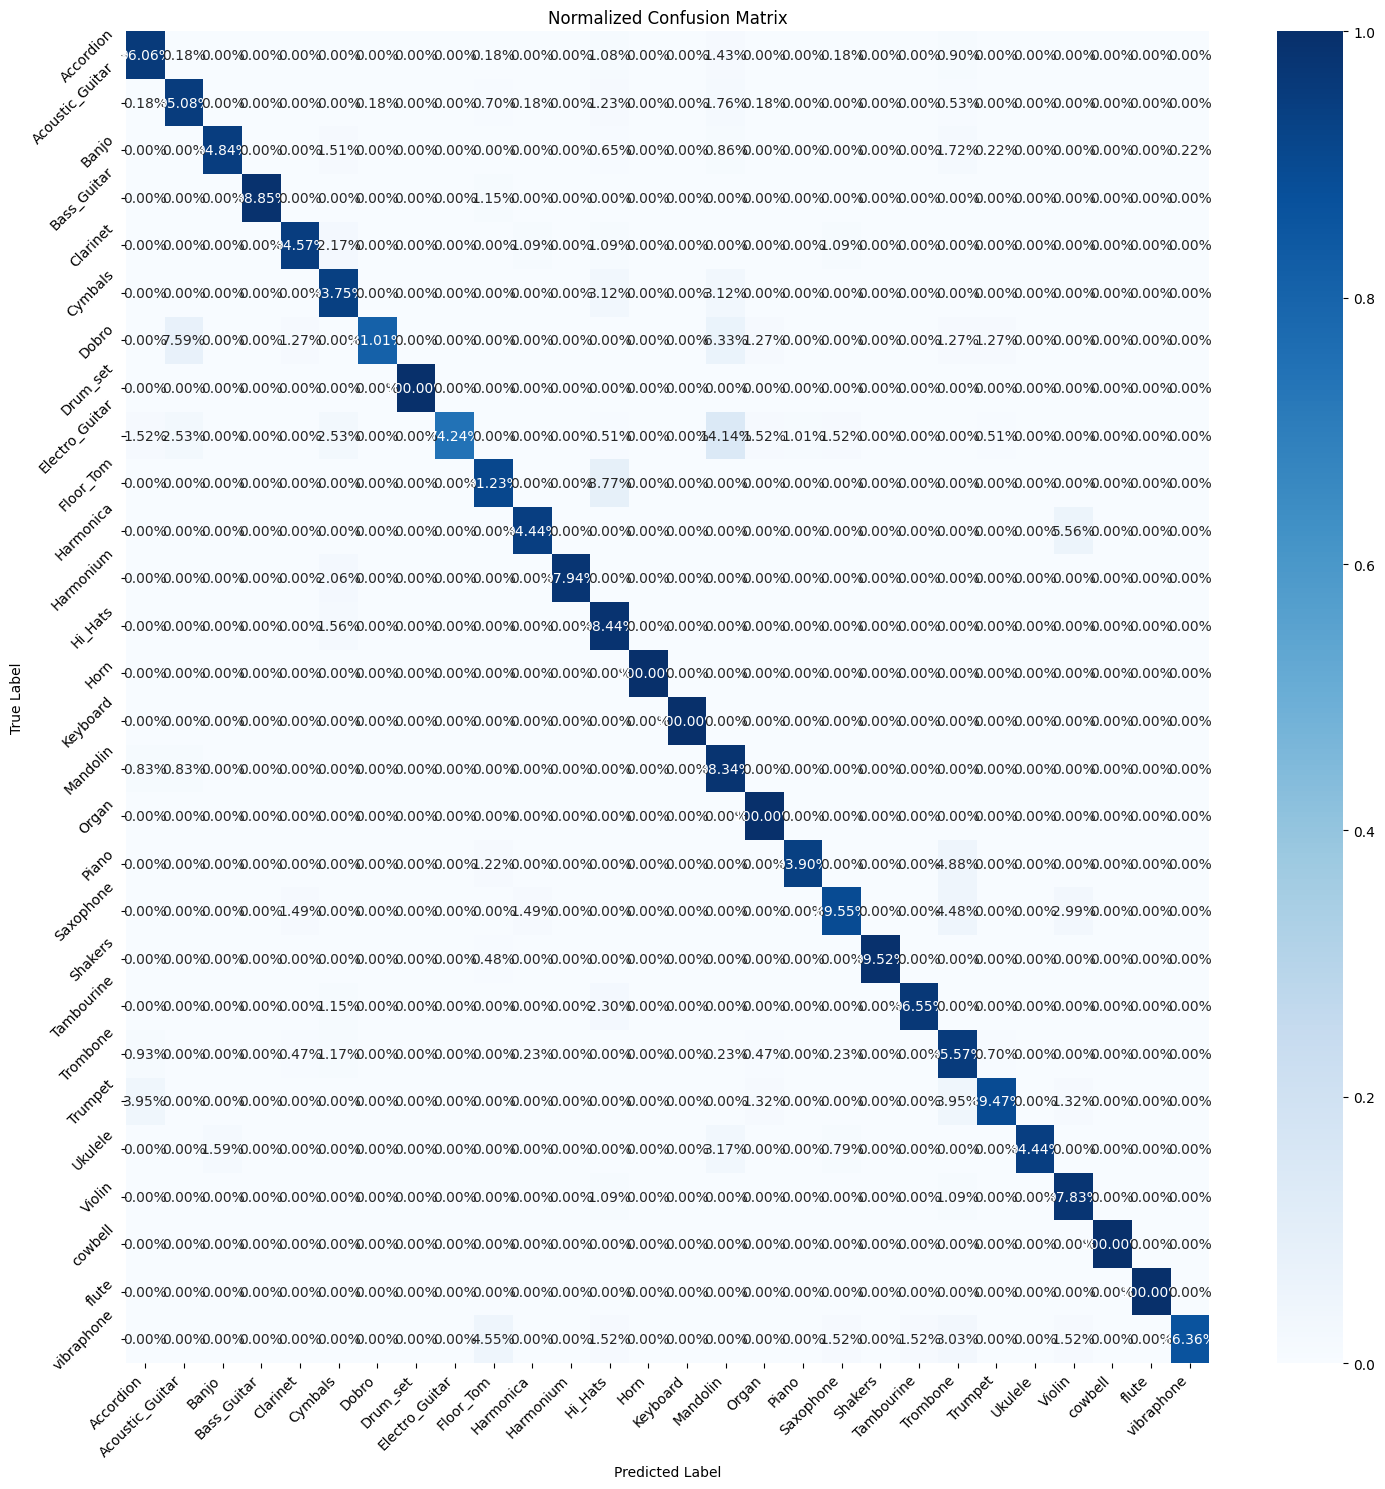


Classification Report:
                 precision    recall  f1-score   support

      Accordion       0.97      0.96      0.97       558
Acoustic_Guitar       0.97      0.95      0.96       569
          Banjo       1.00      0.95      0.97       465
    Bass_Guitar       1.00      0.99      0.99       523
       Clarinet       0.96      0.95      0.95        92
        Cymbals       0.55      0.94      0.69        32
          Dobro       0.98      0.81      0.89        79
       Drum_set       1.00      1.00      1.00       530
 Electro_Guitar       1.00      0.74      0.85       198
      Floor_Tom       0.76      0.91      0.83        57
      Harmonica       0.81      0.94      0.87        18
      Harmonium       1.00      0.98      0.99       194
        Hi_Hats       0.69      0.98      0.81        64
           Horn       1.00      1.00      1.00       188
       Keyboard       1.00      1.00      1.00       291
       Mandolin       0.85      0.98      0.91       362
      

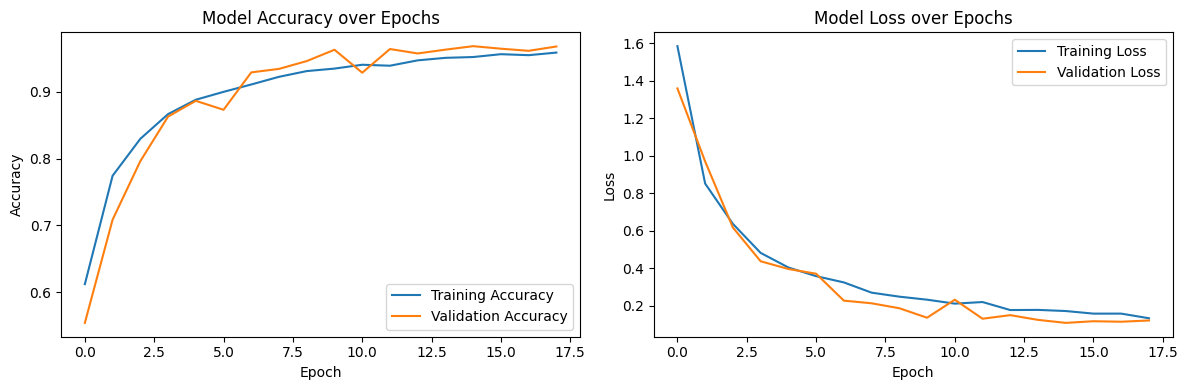

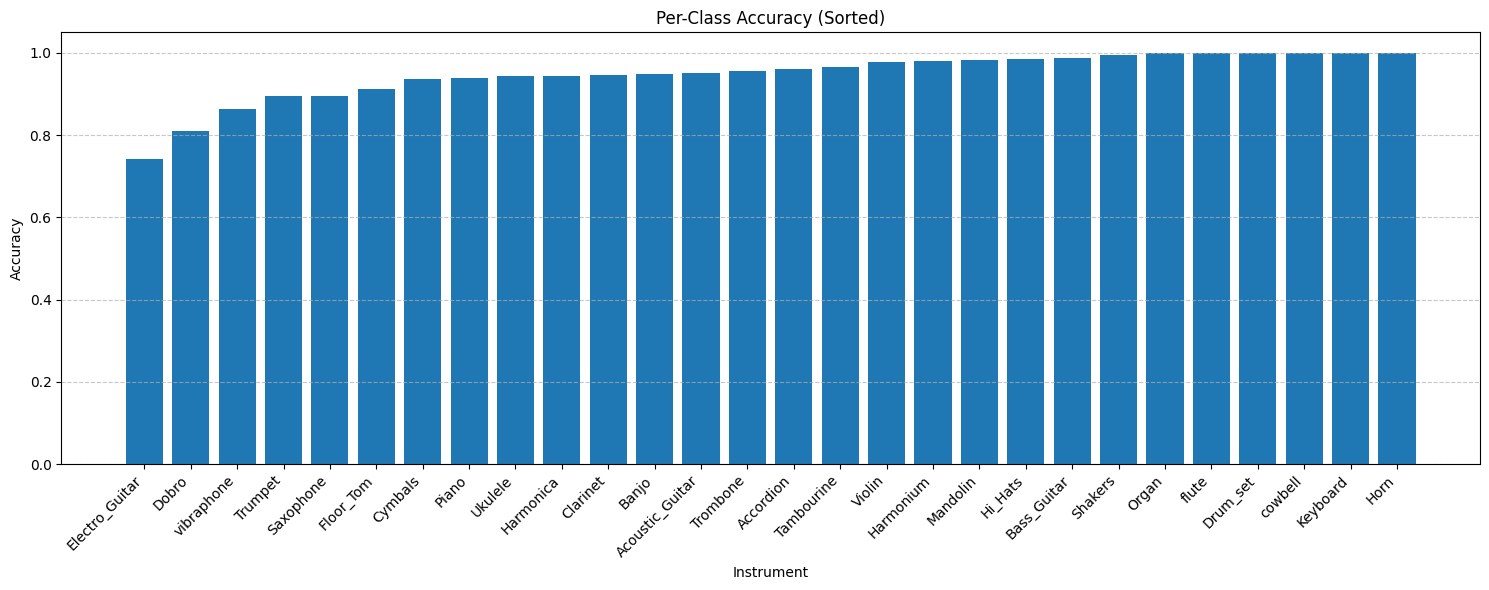

In [68]:
final_evaluation = evaluate_model_performance(
    best_model,
    generator_data['test_generator'],
    generator_data['test_steps'],
    label_encoder,
    history=history.history
)

In [69]:

best_model.save("Best_Instrument_Classifier.keras")